In [1]:
# Parameters
patient = 2
device = "cpu"


In [2]:
%config InlineBackend.figure_format = 'svg'

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pickle
from models import NonLinearController, ClosedLoopSystem
from Rens import REN_IQC_gamma, DualREN
from utils import set_params, set_QR, ensure_3d
from torch.utils.data import DataLoader, random_split, Subset
from ParametersFunctions import Parameter, PID_functions, MinMaxScalerTorch
from pathlib import Path
import scipy.io as sio
from dataset import LoadData

In [3]:
# Parameters
# ------------
# If ecxecuted with papermill these parameters are overwritten.

patient = globals().get("patient", None)
device = globals().get("device", None)

# if not passed in papermill, set preferred values for manual use
if patient is None:
    patient = 1   # <-- preferred patient for manual use
if device is None:
    device = "cpu"  # <-- preferred device for manual use

# can add like this more optional parameters like batch size, epochs, learning rate, etc.

print(f"[INFO] Training per patient: {patient}    on device: {device}")




# Define simulation parameters
torch.set_default_dtype(torch.float64)

x0, input_dim, output_dim, dim_internal, dim_nl, y_init, IQC_type, gamma, learning_rate, epochs, data_path, model_folder, redo_save, ts, use_noise, num_days = set_params()

[INFO] Training per patient: 2    on device: cpu


In [4]:
#-------------------------2. Generate closed loop data---------------------------------------------


# consecutive days split
train_size = int(num_days*0.8*1440//ts)
val_size = int(num_days*0.1*1440//ts)
test_size = int(num_days*0.1*1440//ts)

# it is normalized, has as method also the scaler to denormalize
dataset = LoadData(patient, data_path, use_noise, train_size+50)


train_dataset = torch.utils.data.Subset(dataset, range(0, train_size+50))
val_dataset   = torch.utils.data.Subset(dataset, range(train_size+50, train_size+50 + val_size))
test_dataset  = torch.utils.data.Subset(dataset, range(train_size+50 + val_size, train_size + val_size + test_size))

train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)


#------------------------- save scalers ---------------------------------------------------

scaler_glucose = dataset.scaler_glucose
scaler_insulin = dataset.scaler_insulin
scaler_meal    = dataset.scaler_meal

if redo_save:
    # Save the scalers
    # 1. Create models directory
    patient_str = "/paz_" + str(int(patient)).zfill(3)
    patient_model_folder = model_folder + "/" + patient_str
    MODEL_PATH = Path(patient_model_folder)
    MODEL_PATH.mkdir(parents = True, exist_ok = True)
    # 2. save model state dict
    torch.save(scaler_glucose, MODEL_PATH / 'scaler_glucose.pth')
    torch.save(scaler_insulin, MODEL_PATH / 'scaler_insulin.pth')
    torch.save(scaler_meal,    MODEL_PATH / 'scaler_meal.pth')
    
    sio.savemat(MODEL_PATH / 'scalers.mat', {
    'glucose_low':  scaler_glucose.params['low'].item(),
    'glucose_high': scaler_glucose.params['high'].item(),
    'insulin_low':  scaler_insulin.params['low'].item(),
    'insulin_high': scaler_insulin.params['high'].item(),
    'meal_low':     scaler_meal.params['low'].item(),
    'meal_high':    scaler_meal.params['high'].item()
})


C:\Users\pogotar\Desktop\Dottorato\Nonlinear_system_identification_modified\Nonlinear_system_identification_diabetic_patients\models.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  basal = torch.tensor(basal, dtype=torch.float32)
C:\Users\pogotar\Desktop\Dottorato\Nonlinear_system_identification_modified\Nonlinear_system_identification_diabetic_patients\models.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bolus = torch.tensor(bolus, dtype=torch.float32)


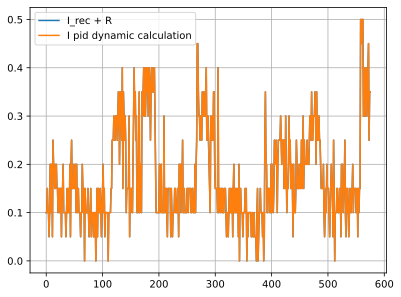

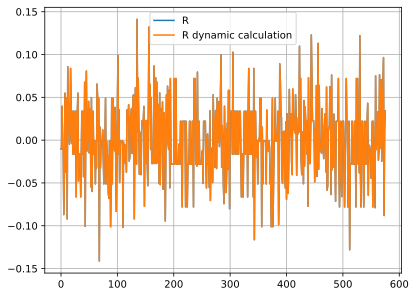

In [5]:
CGM   = (scaler_glucose.denormalize(dataset.CGM.detach())).numpy();              G     = (scaler_glucose.denormalize(dataset.G.detach())).numpy()
                                                                                                                                 
I_sat       = (scaler_insulin.denormalize(dataset.I_sat.detach())).numpy();      I_rec = (scaler_insulin.denormalize(dataset.I_rec.detach())).numpy();       
I_sat_rec   = (scaler_insulin.denormalize(dataset.I_sat_rec.detach())).numpy();  R     = (scaler_insulin.denormalize(dataset.R.detach())).numpy()

M       = (scaler_meal.denormalize(dataset.M.detach())).numpy();                 MH    = (scaler_meal.denormalize(dataset.MH.detach())).numpy();          
MH_rec  = (scaler_meal.denormalize(dataset.MH_rec.detach())).numpy()
H       = (scaler_meal.denormalize(dataset.H.detach())).numpy();                 H_rec = (scaler_meal.denormalize(dataset.H_rec.detach())).numpy();     

# R = I_sat (from .mat) - I_rec (exiting the PID and before saturation and noise)
# if  use_noise = True, R contains the noise and the saturation effect


# ------------------------- PID controller dynamic simulation ---------------------------------------------------
CGM_torch = dataset.CGM
loaded_parameters = Parameter(patient)
controller = NonLinearController(loaded_parameters, PID_functions, dataset.basal_vec, scaler_glucose, scaler_insulin, scaler_meal, use_noise)
u_pid, u_pid_rwgn, u_pid_rwgn_sat, r = controller(CGM_torch)


u_pid           = scaler_insulin.denormalize(u_pid.detach())
u_pid_rwgn      = scaler_insulin.denormalize(u_pid_rwgn.detach())
u_pid_rwgn_sat  = scaler_insulin.denormalize(u_pid_rwgn_sat.detach())
r               = scaler_insulin.denormalize(r.detach())

plt.figure()
plt.plot(I_rec[:2*1440//ts]+ R[:2*1440//ts], label= 'I_rec + R')
plt.plot(u_pid_rwgn_sat.numpy()[:2*1440//ts], label = 'I pid dynamic calculation');             plt.legend();plt.grid(True); plt.show()

plt.figure()
plt.plot(R[:2*1440//ts], label= 'R')
plt.plot(r.numpy()[:2*1440//ts], label = 'R dynamic calculation');                             plt.legend();plt.grid(True); plt.show()


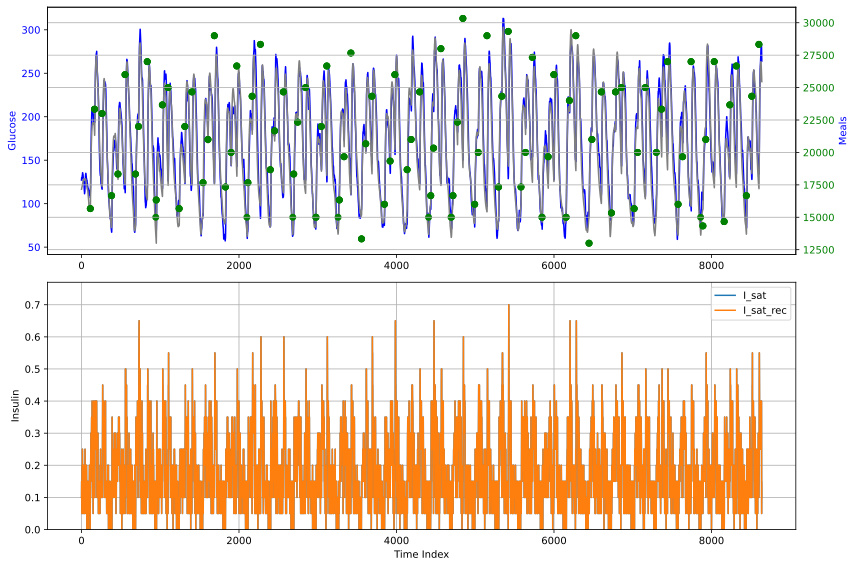

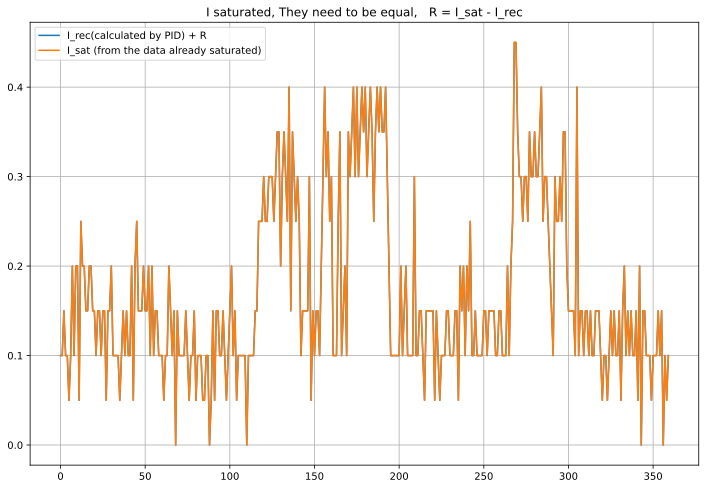

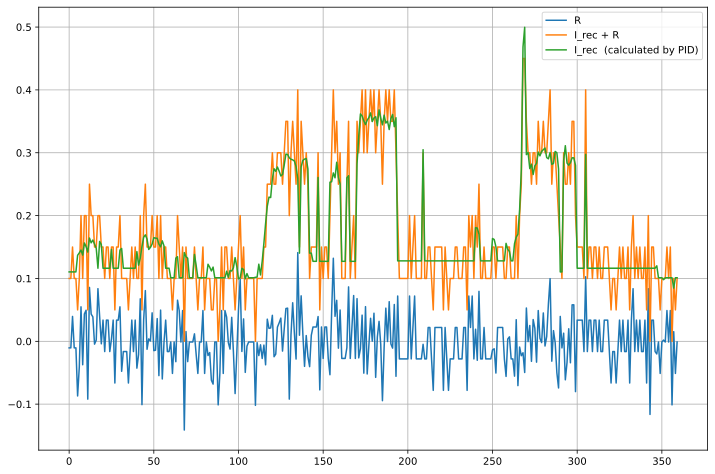

In [6]:
plt.figure(1, figsize=(12, 8))

# Subplot 1
ax1 = plt.subplot(2, 1, 1)
ax1.plot(CGM[:], 'b-', label='Glucose sensor CGM')
ax1.plot(G[:], 'gray', label='Glucose');                                                               ax1.set_ylabel('Glucose', color='b'); ax1.tick_params(axis='y', labelcolor='b'); ax1_right = ax1.twinx()
MHtemp = MH[:].copy()
ax1_right.scatter(np.arange(len(MHtemp))[MHtemp!=0], MHtemp[MHtemp!=0], color='g', label='Meals and hypo');         ax1_right.set_ylabel('Meals', color='b'); ax1_right.tick_params(axis='y', labelcolor='g'); plt.grid(True)

# Subplot 2
ax2 = plt.subplot(2, 1, 2, sharex=ax1)
ax2.plot(range(len(I_sat[:])), I_sat[:].flatten(), label='I_sat')
ax2.plot(range(len(I_sat_rec[:])), I_sat_rec[:], label='I_sat_rec');                                      ax2.set_ylim([0, np.max(I_sat_rec) * 1.1]); ax2.legend(); ax2.set_xlabel('Time Index'); ax2.set_ylabel('Insulin')

plt.tight_layout(); plt.grid(True); plt.show()



plt.figure(3, figsize=(12, 8))
plt.plot(I_rec[:1440//4]+ R[:1440//4], label = 'I_rec(calculated by PID) + R')
plt.plot(I_sat[:1440//4], label= 'I_sat (from the data already saturated)')
plt.title('I saturated, They need to be equal,   R = I_sat - I_rec');                   plt.legend();plt.grid(True); plt.show()

plt.figure(4, figsize=(12, 8))
plt.plot(R[:1440//4], label= 'R')
plt.plot(I_rec[:1440//4]+ R[:1440//4], label= 'I_rec + R')
plt.plot(I_rec[:1440//4], label = 'I_rec  (calculated by PID)');                             plt.legend();plt.grid(True); plt.show()


# plt.figure(5)
# plt.plot(H, label='H')
# plt.plot(H_rec-100, label='H_rec')
# plt.title('Hypoglycemia Treatments Comparison');                                                    plt.legend(); plt.show()
#
# plt.figure(6)
# plt.plot(CGM[:1440//4], 'b-', label='Glucose sensor CGM')
# plt.plot(G[:1440//4], 'gray', label='Glucose')
# plt.figure(1, figsize=(12, 8))


In [7]:
#--------------------------3. Define model for sysid---------------------------------------------


device = torch.device(device if torch.cuda.is_available() else "cpu")

# meal   M 
REN_0 = REN_IQC_gamma(dim_in= input_dim[0], dim_out= output_dim[0], dim_internal=dim_internal[0], dim_nl= dim_nl[0], y_init = y_init[0], QR_fun = set_QR, gammat=gamma[0], IQC_type = IQC_type[0], device=device)

# insulin  I_sat
REN_1 = REN_IQC_gamma(dim_in= input_dim[1], dim_out= output_dim[1], dim_internal=dim_internal[1], dim_nl= dim_nl[1], y_init = y_init[1], QR_fun = set_QR, gammat=gamma[1], IQC_type = IQC_type[1], device=device)

REN_0 = REN_0.to(device)
REN_1 = REN_1.to(device)

#create the closed loop with the identified model
# closed_loop_G = ClosedLoopSystem(REN_G, controller)

#--------------------------4. Define the loss function and optimizer---------------------------------------------
MSE = nn.MSELoss()

optimizer = torch.optim.Adam( list(REN_0.parameters()) + list(REN_1.parameters()),   lr=learning_rate)
optimizer.zero_grad()

C:\Users\pogotar\Desktop\Dottorato\Nonlinear_system_identification_modified\Nonlinear_system_identification_diabetic_patients\Rens.py:313: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4419.)
  self.x = torch.linalg.lstsq(self.C2, y_init.squeeze(1).T)[0].T.unsqueeze(0).unsqueeze(0)


In [8]:
#--------------------------5. Training---------------------------------------------------------------------

torch.set_default_device(device)      # default tensor device
torch.set_default_dtype(torch.float32)  # default tensor dtype
print(f"[INFO] Training on device: {device}")

REN_0.to(device); REN_1.to(device)
train_losses = []
val_losses = []  # Store validation losses across epochs
for epoch in range(epochs):
    # ---------------- TRAINING ---------------- #
    REN_0.train(); REN_1.train()
    loss_epoch = 0.0  # Accumulate training loss

    
    for u0_batch, _, _, u1_batch, y_batch, _ in train_loader: # MH, I_rec (PID), R (noise + sat), I_sat (I_rec + R), CGM, time
        
        u0_batch, u1_batch, y_batch= ensure_3d(u0_batch), ensure_3d(u1_batch), ensure_3d(y_batch) # batch_size, time_horizon, input_dim
        u0_batch, u1_batch, y_batch = u0_batch.to(device), u1_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        REN_0.reset(); REN_1.reset()

        y0_hat_train = REN_0(u0_batch) # forward
        y1_hat_train = REN_1(u1_batch) # forward
        y_hat_train = y0_hat_train - y1_hat_train 
        # with monotonicity we have forced a positive response from the insulin REN (REN_1) 
        # but from real-world knowledge it is a negative relation

        loss_batch = MSE(y_hat_train, y_batch)

        loss_batch.backward()
        optimizer.step()
        loss_epoch += loss_batch.item()

    loss_epoch /= len(train_loader)
    train_losses.append(loss_epoch)

    # ---------------- VALIDATION ---------------- #
    REN_0.eval(); REN_1.eval()
    loss_val_epoch = 0.0

    with torch.no_grad():
        for u0_batch, _, _, u1_batch, y_batch, _ in val_loader: # MH, I_rec (PID), R (noise + sat), I_sat (I_rec + R), CGM, time

            u0_batch, u1_batch, y_batch= ensure_3d(u0_batch), ensure_3d(u1_batch), ensure_3d(y_batch)
            u0_batch, u1_batch, y_batch = u0_batch.to(device), u1_batch.to(device), y_batch.to(device)
            
            REN_0.reset(); REN_1.reset()

            y0_hat_val = REN_0(u0_batch)
            y1_hat_val = REN_1(u1_batch)# select the correct U
            y_hat_val = y0_hat_val - y1_hat_val
            
            loss_batch_val = MSE(y_hat_val, y_batch)

            loss_val_epoch += loss_batch_val.item()

    if epoch == 0 or loss_val_epoch < min_val_loss:
        min_val_loss = loss_val_epoch
        epoch_when_model_saved = epoch
        candidate_REN_0 = REN_0
        candidate_REN_1 = REN_1

    loss_val_epoch /= len(val_loader)
    val_losses.append(loss_val_epoch)  # Store validation loss for plotting

    print(f"Epoch: {epoch + 1} \t||\t Training Loss: {loss_epoch:.6f} \t||\t Validation Loss: {loss_val_epoch:.6f}")

if redo_save:
    # model on CPU before saving
    candidate_REN_0_cpu = candidate_REN_0.to('cpu')
    candidate_REN_1_cpu = candidate_REN_1.to('cpu')

    # Save the best model
    # 1. Create models directory
    patient_str = "/paz_" + str(int(patient)).zfill(3)
    patient_model_folder = model_folder + "/"+ "strategy_1" + "/" + patient_str
    MODEL_PATH = Path(patient_model_folder)
    MODEL_PATH.mkdir(parents = True, exist_ok = True)
    # 2. save model state dict
    torch.save({
    'REN_0_state_dict': candidate_REN_0_cpu.state_dict(),
    'REN_1_state_dict': candidate_REN_1_cpu.state_dict()}, MODEL_PATH / 'trained_models.pth')


    # save .mat
    np_x0 = x0.detach().cpu().numpy(); np_input_dim = np.array(input_dim); np_output_dim = np.array(output_dim); np_dim_internal =np.array(dim_internal); np_dim_nl = np.array(dim_nl)
    np_y_init = y_init.cpu().numpy(); np_gamma = gamma.cpu().numpy()
    
    # 4. Create params directory
    params_folder = Path(patient_model_folder) / "params"
    params_folder.mkdir(parents=True, exist_ok=True)
    scipy.io.savemat(params_folder / 'parameters.mat', {'train_losses': train_losses, 'val_losses': val_losses, 'epoch_when_model_saved': epoch_when_model_saved, 'x0': np_x0, 'input_dim': np_input_dim, 'output_dim': np_output_dim, 'dim_internal': np_dim_internal, 'dim_nl': np_dim_nl, 'y_init': np_y_init, 'gamma': np_gamma})


[INFO] Training on device: cpu


Epoch: 1 	||	 Training Loss: 0.242255 	||	 Validation Loss: 0.246312


Epoch: 2 	||	 Training Loss: 0.238598 	||	 Validation Loss: 0.242611


Epoch: 3 	||	 Training Loss: 0.234986 	||	 Validation Loss: 0.238953


Epoch: 4 	||	 Training Loss: 0.231418 	||	 Validation Loss: 0.235339


Epoch: 5 	||	 Training Loss: 0.227894 	||	 Validation Loss: 0.231766


Epoch: 6 	||	 Training Loss: 0.224411 	||	 Validation Loss: 0.228233


Epoch: 7 	||	 Training Loss: 0.220971 	||	 Validation Loss: 0.224741


Epoch: 8 	||	 Training Loss: 0.217570 	||	 Validation Loss: 0.221286


Epoch: 9 	||	 Training Loss: 0.214209 	||	 Validation Loss: 0.217868


Epoch: 10 	||	 Training Loss: 0.210885 	||	 Validation Loss: 0.214485


Epoch: 11 	||	 Training Loss: 0.207597 	||	 Validation Loss: 0.211136


Epoch: 12 	||	 Training Loss: 0.204343 	||	 Validation Loss: 0.207819


Epoch: 13 	||	 Training Loss: 0.201123 	||	 Validation Loss: 0.204532


Epoch: 14 	||	 Training Loss: 0.197932 	||	 Validation Loss: 0.201272


Epoch: 15 	||	 Training Loss: 0.194771 	||	 Validation Loss: 0.198038


Epoch: 16 	||	 Training Loss: 0.191636 	||	 Validation Loss: 0.194828


Epoch: 17 	||	 Training Loss: 0.188526 	||	 Validation Loss: 0.191640


Epoch: 18 	||	 Training Loss: 0.185438 	||	 Validation Loss: 0.188471


Epoch: 19 	||	 Training Loss: 0.182371 	||	 Validation Loss: 0.185319


Epoch: 20 	||	 Training Loss: 0.179323 	||	 Validation Loss: 0.182184


Epoch: 21 	||	 Training Loss: 0.176291 	||	 Validation Loss: 0.179063


Epoch: 22 	||	 Training Loss: 0.173275 	||	 Validation Loss: 0.175956


Epoch: 23 	||	 Training Loss: 0.170274 	||	 Validation Loss: 0.172860


Epoch: 24 	||	 Training Loss: 0.167285 	||	 Validation Loss: 0.169774


Epoch: 25 	||	 Training Loss: 0.164307 	||	 Validation Loss: 0.166697


Epoch: 26 	||	 Training Loss: 0.161340 	||	 Validation Loss: 0.163629


Epoch: 27 	||	 Training Loss: 0.158381 	||	 Validation Loss: 0.160567


Epoch: 28 	||	 Training Loss: 0.155431 	||	 Validation Loss: 0.157511


Epoch: 29 	||	 Training Loss: 0.152488 	||	 Validation Loss: 0.154459


Epoch: 30 	||	 Training Loss: 0.149551 	||	 Validation Loss: 0.151412


Epoch: 31 	||	 Training Loss: 0.146618 	||	 Validation Loss: 0.148368


Epoch: 32 	||	 Training Loss: 0.143691 	||	 Validation Loss: 0.145326


Epoch: 33 	||	 Training Loss: 0.140766 	||	 Validation Loss: 0.142286


Epoch: 34 	||	 Training Loss: 0.137845 	||	 Validation Loss: 0.139247


Epoch: 35 	||	 Training Loss: 0.134926 	||	 Validation Loss: 0.136208


Epoch: 36 	||	 Training Loss: 0.132009 	||	 Validation Loss: 0.133170


Epoch: 37 	||	 Training Loss: 0.129094 	||	 Validation Loss: 0.130132


Epoch: 38 	||	 Training Loss: 0.126180 	||	 Validation Loss: 0.127094


Epoch: 39 	||	 Training Loss: 0.123267 	||	 Validation Loss: 0.124056


Epoch: 40 	||	 Training Loss: 0.120356 	||	 Validation Loss: 0.121018


Epoch: 41 	||	 Training Loss: 0.117447 	||	 Validation Loss: 0.117982


Epoch: 42 	||	 Training Loss: 0.114540 	||	 Validation Loss: 0.114947


Epoch: 43 	||	 Training Loss: 0.111636 	||	 Validation Loss: 0.111915


Epoch: 44 	||	 Training Loss: 0.108736 	||	 Validation Loss: 0.108886


Epoch: 45 	||	 Training Loss: 0.105841 	||	 Validation Loss: 0.105863


Epoch: 46 	||	 Training Loss: 0.102952 	||	 Validation Loss: 0.102846


Epoch: 47 	||	 Training Loss: 0.100071 	||	 Validation Loss: 0.099838


Epoch: 48 	||	 Training Loss: 0.097199 	||	 Validation Loss: 0.096840


Epoch: 49 	||	 Training Loss: 0.094339 	||	 Validation Loss: 0.093855


Epoch: 50 	||	 Training Loss: 0.091493 	||	 Validation Loss: 0.090885


Epoch: 51 	||	 Training Loss: 0.088663 	||	 Validation Loss: 0.087935


Epoch: 52 	||	 Training Loss: 0.085853 	||	 Validation Loss: 0.085006


Epoch: 53 	||	 Training Loss: 0.083065 	||	 Validation Loss: 0.082102


Epoch: 54 	||	 Training Loss: 0.080303 	||	 Validation Loss: 0.079228


Epoch: 55 	||	 Training Loss: 0.077571 	||	 Validation Loss: 0.076388


Epoch: 56 	||	 Training Loss: 0.074873 	||	 Validation Loss: 0.073586


Epoch: 57 	||	 Training Loss: 0.072214 	||	 Validation Loss: 0.070828


Epoch: 58 	||	 Training Loss: 0.069598 	||	 Validation Loss: 0.068118


Epoch: 59 	||	 Training Loss: 0.067031 	||	 Validation Loss: 0.065464


Epoch: 60 	||	 Training Loss: 0.064518 	||	 Validation Loss: 0.062870


Epoch: 61 	||	 Training Loss: 0.062064 	||	 Validation Loss: 0.060343


Epoch: 62 	||	 Training Loss: 0.059677 	||	 Validation Loss: 0.057889


Epoch: 63 	||	 Training Loss: 0.057362 	||	 Validation Loss: 0.055516


Epoch: 64 	||	 Training Loss: 0.055125 	||	 Validation Loss: 0.053230


Epoch: 65 	||	 Training Loss: 0.052974 	||	 Validation Loss: 0.051038


Epoch: 66 	||	 Training Loss: 0.050915 	||	 Validation Loss: 0.048948


Epoch: 67 	||	 Training Loss: 0.048954 	||	 Validation Loss: 0.046964


Epoch: 68 	||	 Training Loss: 0.047097 	||	 Validation Loss: 0.045094


Epoch: 69 	||	 Training Loss: 0.045351 	||	 Validation Loss: 0.043343


Epoch: 70 	||	 Training Loss: 0.043720 	||	 Validation Loss: 0.041716


Epoch: 71 	||	 Training Loss: 0.042210 	||	 Validation Loss: 0.040217


Epoch: 72 	||	 Training Loss: 0.040823 	||	 Validation Loss: 0.038849


Epoch: 73 	||	 Training Loss: 0.039563 	||	 Validation Loss: 0.037614


Epoch: 74 	||	 Training Loss: 0.038431 	||	 Validation Loss: 0.036511


Epoch: 75 	||	 Training Loss: 0.037426 	||	 Validation Loss: 0.035540


Epoch: 76 	||	 Training Loss: 0.036548 	||	 Validation Loss: 0.034697


Epoch: 77 	||	 Training Loss: 0.035792 	||	 Validation Loss: 0.033977


Epoch: 78 	||	 Training Loss: 0.035155 	||	 Validation Loss: 0.033373


Epoch: 79 	||	 Training Loss: 0.034628 	||	 Validation Loss: 0.032879


Epoch: 80 	||	 Training Loss: 0.034205 	||	 Validation Loss: 0.032482


Epoch: 81 	||	 Training Loss: 0.033874 	||	 Validation Loss: 0.032174


Epoch: 82 	||	 Training Loss: 0.033625 	||	 Validation Loss: 0.031940


Epoch: 83 	||	 Training Loss: 0.033446 	||	 Validation Loss: 0.031769


Epoch: 84 	||	 Training Loss: 0.033324 	||	 Validation Loss: 0.031648


Epoch: 85 	||	 Training Loss: 0.033246 	||	 Validation Loss: 0.031564


Epoch: 86 	||	 Training Loss: 0.033200 	||	 Validation Loss: 0.031505


Epoch: 87 	||	 Training Loss: 0.033174 	||	 Validation Loss: 0.031461


Epoch: 88 	||	 Training Loss: 0.033157 	||	 Validation Loss: 0.031421


Epoch: 89 	||	 Training Loss: 0.033141 	||	 Validation Loss: 0.031379


Epoch: 90 	||	 Training Loss: 0.033118 	||	 Validation Loss: 0.031329


Epoch: 91 	||	 Training Loss: 0.033081 	||	 Validation Loss: 0.031265


Epoch: 92 	||	 Training Loss: 0.033027 	||	 Validation Loss: 0.031186


Epoch: 93 	||	 Training Loss: 0.032954 	||	 Validation Loss: 0.031091


Epoch: 94 	||	 Training Loss: 0.032861 	||	 Validation Loss: 0.030979


Epoch: 95 	||	 Training Loss: 0.032749 	||	 Validation Loss: 0.030854


Epoch: 96 	||	 Training Loss: 0.032619 	||	 Validation Loss: 0.030716


Epoch: 97 	||	 Training Loss: 0.032474 	||	 Validation Loss: 0.030569


Epoch: 98 	||	 Training Loss: 0.032318 	||	 Validation Loss: 0.030415


Epoch: 99 	||	 Training Loss: 0.032152 	||	 Validation Loss: 0.030259


Epoch: 100 	||	 Training Loss: 0.031982 	||	 Validation Loss: 0.030102


Epoch: 101 	||	 Training Loss: 0.031810 	||	 Validation Loss: 0.029947


Epoch: 102 	||	 Training Loss: 0.031638 	||	 Validation Loss: 0.029796


Epoch: 103 	||	 Training Loss: 0.031470 	||	 Validation Loss: 0.029651


Epoch: 104 	||	 Training Loss: 0.031306 	||	 Validation Loss: 0.029513


Epoch: 105 	||	 Training Loss: 0.031149 	||	 Validation Loss: 0.029383


Epoch: 106 	||	 Training Loss: 0.031000 	||	 Validation Loss: 0.029261


Epoch: 107 	||	 Training Loss: 0.030859 	||	 Validation Loss: 0.029146


Epoch: 108 	||	 Training Loss: 0.030725 	||	 Validation Loss: 0.029038


Epoch: 109 	||	 Training Loss: 0.030599 	||	 Validation Loss: 0.028937


Epoch: 110 	||	 Training Loss: 0.030481 	||	 Validation Loss: 0.028842


Epoch: 111 	||	 Training Loss: 0.030368 	||	 Validation Loss: 0.028751


Epoch: 112 	||	 Training Loss: 0.030262 	||	 Validation Loss: 0.028664


Epoch: 113 	||	 Training Loss: 0.030160 	||	 Validation Loss: 0.028579


Epoch: 114 	||	 Training Loss: 0.030061 	||	 Validation Loss: 0.028496


Epoch: 115 	||	 Training Loss: 0.029965 	||	 Validation Loss: 0.028414


Epoch: 116 	||	 Training Loss: 0.029871 	||	 Validation Loss: 0.028331


Epoch: 117 	||	 Training Loss: 0.029779 	||	 Validation Loss: 0.028247


Epoch: 118 	||	 Training Loss: 0.029686 	||	 Validation Loss: 0.028162


Epoch: 119 	||	 Training Loss: 0.029594 	||	 Validation Loss: 0.028075


Epoch: 120 	||	 Training Loss: 0.029501 	||	 Validation Loss: 0.027986


Epoch: 121 	||	 Training Loss: 0.029407 	||	 Validation Loss: 0.027895


Epoch: 122 	||	 Training Loss: 0.029312 	||	 Validation Loss: 0.027801


Epoch: 123 	||	 Training Loss: 0.029217 	||	 Validation Loss: 0.027706


Epoch: 124 	||	 Training Loss: 0.029120 	||	 Validation Loss: 0.027608


Epoch: 125 	||	 Training Loss: 0.029022 	||	 Validation Loss: 0.027509


Epoch: 126 	||	 Training Loss: 0.028923 	||	 Validation Loss: 0.027408


Epoch: 127 	||	 Training Loss: 0.028823 	||	 Validation Loss: 0.027305


Epoch: 128 	||	 Training Loss: 0.028723 	||	 Validation Loss: 0.027202


Epoch: 129 	||	 Training Loss: 0.028623 	||	 Validation Loss: 0.027099


Epoch: 130 	||	 Training Loss: 0.028522 	||	 Validation Loss: 0.026994


Epoch: 131 	||	 Training Loss: 0.028422 	||	 Validation Loss: 0.026890


Epoch: 132 	||	 Training Loss: 0.028322 	||	 Validation Loss: 0.026786


Epoch: 133 	||	 Training Loss: 0.028222 	||	 Validation Loss: 0.026682


Epoch: 134 	||	 Training Loss: 0.028122 	||	 Validation Loss: 0.026578


Epoch: 135 	||	 Training Loss: 0.028023 	||	 Validation Loss: 0.026475


Epoch: 136 	||	 Training Loss: 0.027925 	||	 Validation Loss: 0.026373


Epoch: 137 	||	 Training Loss: 0.027827 	||	 Validation Loss: 0.026271


Epoch: 138 	||	 Training Loss: 0.027729 	||	 Validation Loss: 0.026171


Epoch: 139 	||	 Training Loss: 0.027633 	||	 Validation Loss: 0.026071


Epoch: 140 	||	 Training Loss: 0.027537 	||	 Validation Loss: 0.025972


Epoch: 141 	||	 Training Loss: 0.027441 	||	 Validation Loss: 0.025874


Epoch: 142 	||	 Training Loss: 0.027346 	||	 Validation Loss: 0.025776


Epoch: 143 	||	 Training Loss: 0.027251 	||	 Validation Loss: 0.025680


Epoch: 144 	||	 Training Loss: 0.027157 	||	 Validation Loss: 0.025584


Epoch: 145 	||	 Training Loss: 0.027063 	||	 Validation Loss: 0.025489


Epoch: 146 	||	 Training Loss: 0.026970 	||	 Validation Loss: 0.025395


Epoch: 147 	||	 Training Loss: 0.026877 	||	 Validation Loss: 0.025302


Epoch: 148 	||	 Training Loss: 0.026784 	||	 Validation Loss: 0.025209


Epoch: 149 	||	 Training Loss: 0.026692 	||	 Validation Loss: 0.025118


Epoch: 150 	||	 Training Loss: 0.026600 	||	 Validation Loss: 0.025027


Epoch: 151 	||	 Training Loss: 0.026509 	||	 Validation Loss: 0.024937


Epoch: 152 	||	 Training Loss: 0.026418 	||	 Validation Loss: 0.024847


Epoch: 153 	||	 Training Loss: 0.026328 	||	 Validation Loss: 0.024759


Epoch: 154 	||	 Training Loss: 0.026238 	||	 Validation Loss: 0.024671


Epoch: 155 	||	 Training Loss: 0.026149 	||	 Validation Loss: 0.024584


Epoch: 156 	||	 Training Loss: 0.026061 	||	 Validation Loss: 0.024498


Epoch: 157 	||	 Training Loss: 0.025973 	||	 Validation Loss: 0.024413


Epoch: 158 	||	 Training Loss: 0.025886 	||	 Validation Loss: 0.024328


Epoch: 159 	||	 Training Loss: 0.025799 	||	 Validation Loss: 0.024244


Epoch: 160 	||	 Training Loss: 0.025713 	||	 Validation Loss: 0.024161


Epoch: 161 	||	 Training Loss: 0.025628 	||	 Validation Loss: 0.024078


Epoch: 162 	||	 Training Loss: 0.025544 	||	 Validation Loss: 0.023996


Epoch: 163 	||	 Training Loss: 0.025460 	||	 Validation Loss: 0.023914


Epoch: 164 	||	 Training Loss: 0.025377 	||	 Validation Loss: 0.023833


Epoch: 165 	||	 Training Loss: 0.025295 	||	 Validation Loss: 0.023753


Epoch: 166 	||	 Training Loss: 0.025214 	||	 Validation Loss: 0.023673


Epoch: 167 	||	 Training Loss: 0.025133 	||	 Validation Loss: 0.023594


Epoch: 168 	||	 Training Loss: 0.025052 	||	 Validation Loss: 0.023515


Epoch: 169 	||	 Training Loss: 0.024973 	||	 Validation Loss: 0.023436


Epoch: 170 	||	 Training Loss: 0.024894 	||	 Validation Loss: 0.023358


Epoch: 171 	||	 Training Loss: 0.024816 	||	 Validation Loss: 0.023280


Epoch: 172 	||	 Training Loss: 0.024738 	||	 Validation Loss: 0.023203


Epoch: 173 	||	 Training Loss: 0.024661 	||	 Validation Loss: 0.023127


Epoch: 174 	||	 Training Loss: 0.024585 	||	 Validation Loss: 0.023050


Epoch: 175 	||	 Training Loss: 0.024509 	||	 Validation Loss: 0.022975


Epoch: 176 	||	 Training Loss: 0.024434 	||	 Validation Loss: 0.022900


Epoch: 177 	||	 Training Loss: 0.024360 	||	 Validation Loss: 0.022825


Epoch: 178 	||	 Training Loss: 0.024286 	||	 Validation Loss: 0.022752


Epoch: 179 	||	 Training Loss: 0.024213 	||	 Validation Loss: 0.022678


Epoch: 180 	||	 Training Loss: 0.024141 	||	 Validation Loss: 0.022606


Epoch: 181 	||	 Training Loss: 0.024069 	||	 Validation Loss: 0.022534


Epoch: 182 	||	 Training Loss: 0.023998 	||	 Validation Loss: 0.022463


Epoch: 183 	||	 Training Loss: 0.023928 	||	 Validation Loss: 0.022392


Epoch: 184 	||	 Training Loss: 0.023859 	||	 Validation Loss: 0.022323


Epoch: 185 	||	 Training Loss: 0.023790 	||	 Validation Loss: 0.022253


Epoch: 186 	||	 Training Loss: 0.023721 	||	 Validation Loss: 0.022185


Epoch: 187 	||	 Training Loss: 0.023653 	||	 Validation Loss: 0.022118


Epoch: 188 	||	 Training Loss: 0.023586 	||	 Validation Loss: 0.022051


Epoch: 189 	||	 Training Loss: 0.023520 	||	 Validation Loss: 0.021985


Epoch: 190 	||	 Training Loss: 0.023454 	||	 Validation Loss: 0.021919


Epoch: 191 	||	 Training Loss: 0.023389 	||	 Validation Loss: 0.021855


Epoch: 192 	||	 Training Loss: 0.023324 	||	 Validation Loss: 0.021791


Epoch: 193 	||	 Training Loss: 0.023260 	||	 Validation Loss: 0.021728


Epoch: 194 	||	 Training Loss: 0.023196 	||	 Validation Loss: 0.021665


Epoch: 195 	||	 Training Loss: 0.023133 	||	 Validation Loss: 0.021603


Epoch: 196 	||	 Training Loss: 0.023071 	||	 Validation Loss: 0.021542


Epoch: 197 	||	 Training Loss: 0.023009 	||	 Validation Loss: 0.021481


Epoch: 198 	||	 Training Loss: 0.022947 	||	 Validation Loss: 0.021421


Epoch: 199 	||	 Training Loss: 0.022886 	||	 Validation Loss: 0.021361


Epoch: 200 	||	 Training Loss: 0.022826 	||	 Validation Loss: 0.021302


Epoch: 201 	||	 Training Loss: 0.022766 	||	 Validation Loss: 0.021243


Epoch: 202 	||	 Training Loss: 0.022706 	||	 Validation Loss: 0.021184


Epoch: 203 	||	 Training Loss: 0.022647 	||	 Validation Loss: 0.021126


Epoch: 204 	||	 Training Loss: 0.022588 	||	 Validation Loss: 0.021069


Epoch: 205 	||	 Training Loss: 0.022530 	||	 Validation Loss: 0.021012


Epoch: 206 	||	 Training Loss: 0.022472 	||	 Validation Loss: 0.020955


Epoch: 207 	||	 Training Loss: 0.022414 	||	 Validation Loss: 0.020898


Epoch: 208 	||	 Training Loss: 0.022356 	||	 Validation Loss: 0.020842


Epoch: 209 	||	 Training Loss: 0.022299 	||	 Validation Loss: 0.020786


Epoch: 210 	||	 Training Loss: 0.022242 	||	 Validation Loss: 0.020731


Epoch: 211 	||	 Training Loss: 0.022186 	||	 Validation Loss: 0.020675


Epoch: 212 	||	 Training Loss: 0.022129 	||	 Validation Loss: 0.020620


Epoch: 213 	||	 Training Loss: 0.022073 	||	 Validation Loss: 0.020565


Epoch: 214 	||	 Training Loss: 0.022017 	||	 Validation Loss: 0.020510


Epoch: 215 	||	 Training Loss: 0.021962 	||	 Validation Loss: 0.020456


Epoch: 216 	||	 Training Loss: 0.021906 	||	 Validation Loss: 0.020402


Epoch: 217 	||	 Training Loss: 0.021851 	||	 Validation Loss: 0.020348


Epoch: 218 	||	 Training Loss: 0.021796 	||	 Validation Loss: 0.020294


Epoch: 219 	||	 Training Loss: 0.021741 	||	 Validation Loss: 0.020240


Epoch: 220 	||	 Training Loss: 0.021686 	||	 Validation Loss: 0.020187


Epoch: 221 	||	 Training Loss: 0.021631 	||	 Validation Loss: 0.020134


Epoch: 222 	||	 Training Loss: 0.021576 	||	 Validation Loss: 0.020081


Epoch: 223 	||	 Training Loss: 0.021521 	||	 Validation Loss: 0.020028


Epoch: 224 	||	 Training Loss: 0.021466 	||	 Validation Loss: 0.019975


Epoch: 225 	||	 Training Loss: 0.021412 	||	 Validation Loss: 0.019922


Epoch: 226 	||	 Training Loss: 0.021357 	||	 Validation Loss: 0.019870


Epoch: 227 	||	 Training Loss: 0.021303 	||	 Validation Loss: 0.019817


Epoch: 228 	||	 Training Loss: 0.021248 	||	 Validation Loss: 0.019764


Epoch: 229 	||	 Training Loss: 0.021193 	||	 Validation Loss: 0.019712


Epoch: 230 	||	 Training Loss: 0.021138 	||	 Validation Loss: 0.019660


Epoch: 231 	||	 Training Loss: 0.021084 	||	 Validation Loss: 0.019607


Epoch: 232 	||	 Training Loss: 0.021029 	||	 Validation Loss: 0.019555


Epoch: 233 	||	 Training Loss: 0.020974 	||	 Validation Loss: 0.019502


Epoch: 234 	||	 Training Loss: 0.020919 	||	 Validation Loss: 0.019450


Epoch: 235 	||	 Training Loss: 0.020864 	||	 Validation Loss: 0.019397


Epoch: 236 	||	 Training Loss: 0.020808 	||	 Validation Loss: 0.019344


Epoch: 237 	||	 Training Loss: 0.020753 	||	 Validation Loss: 0.019291


Epoch: 238 	||	 Training Loss: 0.020697 	||	 Validation Loss: 0.019239


Epoch: 239 	||	 Training Loss: 0.020642 	||	 Validation Loss: 0.019185


Epoch: 240 	||	 Training Loss: 0.020586 	||	 Validation Loss: 0.019132


Epoch: 241 	||	 Training Loss: 0.020530 	||	 Validation Loss: 0.019079


Epoch: 242 	||	 Training Loss: 0.020474 	||	 Validation Loss: 0.019026


Epoch: 243 	||	 Training Loss: 0.020417 	||	 Validation Loss: 0.018972


Epoch: 244 	||	 Training Loss: 0.020360 	||	 Validation Loss: 0.018918


Epoch: 245 	||	 Training Loss: 0.020304 	||	 Validation Loss: 0.018864


Epoch: 246 	||	 Training Loss: 0.020246 	||	 Validation Loss: 0.018810


Epoch: 247 	||	 Training Loss: 0.020189 	||	 Validation Loss: 0.018756


Epoch: 248 	||	 Training Loss: 0.020132 	||	 Validation Loss: 0.018702


Epoch: 249 	||	 Training Loss: 0.020074 	||	 Validation Loss: 0.018647


Epoch: 250 	||	 Training Loss: 0.020016 	||	 Validation Loss: 0.018593


Epoch: 251 	||	 Training Loss: 0.019957 	||	 Validation Loss: 0.018538


Epoch: 252 	||	 Training Loss: 0.019899 	||	 Validation Loss: 0.018483


Epoch: 253 	||	 Training Loss: 0.019840 	||	 Validation Loss: 0.018427


Epoch: 254 	||	 Training Loss: 0.019781 	||	 Validation Loss: 0.018372


Epoch: 255 	||	 Training Loss: 0.019721 	||	 Validation Loss: 0.018316


Epoch: 256 	||	 Training Loss: 0.019662 	||	 Validation Loss: 0.018260


Epoch: 257 	||	 Training Loss: 0.019602 	||	 Validation Loss: 0.018204


Epoch: 258 	||	 Training Loss: 0.019541 	||	 Validation Loss: 0.018147


Epoch: 259 	||	 Training Loss: 0.019481 	||	 Validation Loss: 0.018091


Epoch: 260 	||	 Training Loss: 0.019420 	||	 Validation Loss: 0.018034


Epoch: 261 	||	 Training Loss: 0.019359 	||	 Validation Loss: 0.017977


Epoch: 262 	||	 Training Loss: 0.019297 	||	 Validation Loss: 0.017919


Epoch: 263 	||	 Training Loss: 0.019235 	||	 Validation Loss: 0.017861


Epoch: 264 	||	 Training Loss: 0.019173 	||	 Validation Loss: 0.017803


Epoch: 265 	||	 Training Loss: 0.019111 	||	 Validation Loss: 0.017745


Epoch: 266 	||	 Training Loss: 0.019048 	||	 Validation Loss: 0.017686


Epoch: 267 	||	 Training Loss: 0.018984 	||	 Validation Loss: 0.017627


Epoch: 268 	||	 Training Loss: 0.018921 	||	 Validation Loss: 0.017568


Epoch: 269 	||	 Training Loss: 0.018857 	||	 Validation Loss: 0.017509


Epoch: 270 	||	 Training Loss: 0.018793 	||	 Validation Loss: 0.017449


Epoch: 271 	||	 Training Loss: 0.018728 	||	 Validation Loss: 0.017389


Epoch: 272 	||	 Training Loss: 0.018663 	||	 Validation Loss: 0.017329


Epoch: 273 	||	 Training Loss: 0.018598 	||	 Validation Loss: 0.017268


Epoch: 274 	||	 Training Loss: 0.018532 	||	 Validation Loss: 0.017208


Epoch: 275 	||	 Training Loss: 0.018466 	||	 Validation Loss: 0.017146


Epoch: 276 	||	 Training Loss: 0.018400 	||	 Validation Loss: 0.017085


Epoch: 277 	||	 Training Loss: 0.018333 	||	 Validation Loss: 0.017023


Epoch: 278 	||	 Training Loss: 0.018266 	||	 Validation Loss: 0.016961


Epoch: 279 	||	 Training Loss: 0.018199 	||	 Validation Loss: 0.016899


Epoch: 280 	||	 Training Loss: 0.018131 	||	 Validation Loss: 0.016836


Epoch: 281 	||	 Training Loss: 0.018063 	||	 Validation Loss: 0.016773


Epoch: 282 	||	 Training Loss: 0.017994 	||	 Validation Loss: 0.016710


Epoch: 283 	||	 Training Loss: 0.017925 	||	 Validation Loss: 0.016646


Epoch: 284 	||	 Training Loss: 0.017856 	||	 Validation Loss: 0.016582


Epoch: 285 	||	 Training Loss: 0.017786 	||	 Validation Loss: 0.016518


Epoch: 286 	||	 Training Loss: 0.017716 	||	 Validation Loss: 0.016454


Epoch: 287 	||	 Training Loss: 0.017646 	||	 Validation Loss: 0.016389


Epoch: 288 	||	 Training Loss: 0.017575 	||	 Validation Loss: 0.016324


Epoch: 289 	||	 Training Loss: 0.017504 	||	 Validation Loss: 0.016259


Epoch: 290 	||	 Training Loss: 0.017432 	||	 Validation Loss: 0.016193


Epoch: 291 	||	 Training Loss: 0.017361 	||	 Validation Loss: 0.016127


Epoch: 292 	||	 Training Loss: 0.017288 	||	 Validation Loss: 0.016061


Epoch: 293 	||	 Training Loss: 0.017216 	||	 Validation Loss: 0.015994


Epoch: 294 	||	 Training Loss: 0.017143 	||	 Validation Loss: 0.015928


Epoch: 295 	||	 Training Loss: 0.017070 	||	 Validation Loss: 0.015861


Epoch: 296 	||	 Training Loss: 0.016996 	||	 Validation Loss: 0.015793


Epoch: 297 	||	 Training Loss: 0.016923 	||	 Validation Loss: 0.015726


Epoch: 298 	||	 Training Loss: 0.016848 	||	 Validation Loss: 0.015658


Epoch: 299 	||	 Training Loss: 0.016774 	||	 Validation Loss: 0.015590


Epoch: 300 	||	 Training Loss: 0.016699 	||	 Validation Loss: 0.015522


Epoch: 301 	||	 Training Loss: 0.016624 	||	 Validation Loss: 0.015453


Epoch: 302 	||	 Training Loss: 0.016548 	||	 Validation Loss: 0.015384


Epoch: 303 	||	 Training Loss: 0.016473 	||	 Validation Loss: 0.015315


Epoch: 304 	||	 Training Loss: 0.016397 	||	 Validation Loss: 0.015246


Epoch: 305 	||	 Training Loss: 0.016320 	||	 Validation Loss: 0.015177


Epoch: 306 	||	 Training Loss: 0.016244 	||	 Validation Loss: 0.015107


Epoch: 307 	||	 Training Loss: 0.016167 	||	 Validation Loss: 0.015037


Epoch: 308 	||	 Training Loss: 0.016090 	||	 Validation Loss: 0.014968


Epoch: 309 	||	 Training Loss: 0.016013 	||	 Validation Loss: 0.014898


Epoch: 310 	||	 Training Loss: 0.015935 	||	 Validation Loss: 0.014827


Epoch: 311 	||	 Training Loss: 0.015858 	||	 Validation Loss: 0.014757


Epoch: 312 	||	 Training Loss: 0.015780 	||	 Validation Loss: 0.014687


Epoch: 313 	||	 Training Loss: 0.015702 	||	 Validation Loss: 0.014616


Epoch: 314 	||	 Training Loss: 0.015624 	||	 Validation Loss: 0.014546


Epoch: 315 	||	 Training Loss: 0.015546 	||	 Validation Loss: 0.014476


Epoch: 316 	||	 Training Loss: 0.015467 	||	 Validation Loss: 0.014405


Epoch: 317 	||	 Training Loss: 0.015389 	||	 Validation Loss: 0.014334


Epoch: 318 	||	 Training Loss: 0.015310 	||	 Validation Loss: 0.014264


Epoch: 319 	||	 Training Loss: 0.015232 	||	 Validation Loss: 0.014194


Epoch: 320 	||	 Training Loss: 0.015153 	||	 Validation Loss: 0.014123


Epoch: 321 	||	 Training Loss: 0.015075 	||	 Validation Loss: 0.014053


Epoch: 322 	||	 Training Loss: 0.014996 	||	 Validation Loss: 0.013983


Epoch: 323 	||	 Training Loss: 0.014918 	||	 Validation Loss: 0.013913


Epoch: 324 	||	 Training Loss: 0.014839 	||	 Validation Loss: 0.013843


Epoch: 325 	||	 Training Loss: 0.014761 	||	 Validation Loss: 0.013774


Epoch: 326 	||	 Training Loss: 0.014683 	||	 Validation Loss: 0.013704


Epoch: 327 	||	 Training Loss: 0.014605 	||	 Validation Loss: 0.013635


Epoch: 328 	||	 Training Loss: 0.014528 	||	 Validation Loss: 0.013567


Epoch: 329 	||	 Training Loss: 0.014450 	||	 Validation Loss: 0.013498


Epoch: 330 	||	 Training Loss: 0.014373 	||	 Validation Loss: 0.013430


Epoch: 331 	||	 Training Loss: 0.014296 	||	 Validation Loss: 0.013363


Epoch: 332 	||	 Training Loss: 0.014220 	||	 Validation Loss: 0.013296


Epoch: 333 	||	 Training Loss: 0.014143 	||	 Validation Loss: 0.013229


Epoch: 334 	||	 Training Loss: 0.014068 	||	 Validation Loss: 0.013163


Epoch: 335 	||	 Training Loss: 0.013992 	||	 Validation Loss: 0.013097


Epoch: 336 	||	 Training Loss: 0.013918 	||	 Validation Loss: 0.013032


Epoch: 337 	||	 Training Loss: 0.013843 	||	 Validation Loss: 0.012968


Epoch: 338 	||	 Training Loss: 0.013770 	||	 Validation Loss: 0.012904


Epoch: 339 	||	 Training Loss: 0.013697 	||	 Validation Loss: 0.012841


Epoch: 340 	||	 Training Loss: 0.013624 	||	 Validation Loss: 0.012778


Epoch: 341 	||	 Training Loss: 0.013552 	||	 Validation Loss: 0.012717


Epoch: 342 	||	 Training Loss: 0.013481 	||	 Validation Loss: 0.012656


Epoch: 343 	||	 Training Loss: 0.013411 	||	 Validation Loss: 0.012595


Epoch: 344 	||	 Training Loss: 0.013341 	||	 Validation Loss: 0.012536


Epoch: 345 	||	 Training Loss: 0.013272 	||	 Validation Loss: 0.012478


Epoch: 346 	||	 Training Loss: 0.013204 	||	 Validation Loss: 0.012420


Epoch: 347 	||	 Training Loss: 0.013137 	||	 Validation Loss: 0.012363


Epoch: 348 	||	 Training Loss: 0.013071 	||	 Validation Loss: 0.012307


Epoch: 349 	||	 Training Loss: 0.013005 	||	 Validation Loss: 0.012252


Epoch: 350 	||	 Training Loss: 0.012941 	||	 Validation Loss: 0.012198


Epoch: 351 	||	 Training Loss: 0.012877 	||	 Validation Loss: 0.012145


Epoch: 352 	||	 Training Loss: 0.012814 	||	 Validation Loss: 0.012093


Epoch: 353 	||	 Training Loss: 0.012753 	||	 Validation Loss: 0.012042


Epoch: 354 	||	 Training Loss: 0.012692 	||	 Validation Loss: 0.011992


Epoch: 355 	||	 Training Loss: 0.012633 	||	 Validation Loss: 0.011943


Epoch: 356 	||	 Training Loss: 0.012574 	||	 Validation Loss: 0.011895


Epoch: 357 	||	 Training Loss: 0.012516 	||	 Validation Loss: 0.011848


Epoch: 358 	||	 Training Loss: 0.012460 	||	 Validation Loss: 0.011802


Epoch: 359 	||	 Training Loss: 0.012404 	||	 Validation Loss: 0.011757


Epoch: 360 	||	 Training Loss: 0.012350 	||	 Validation Loss: 0.011713


Epoch: 361 	||	 Training Loss: 0.012296 	||	 Validation Loss: 0.011670


Epoch: 362 	||	 Training Loss: 0.012244 	||	 Validation Loss: 0.011627


Epoch: 363 	||	 Training Loss: 0.012192 	||	 Validation Loss: 0.011586


Epoch: 364 	||	 Training Loss: 0.012142 	||	 Validation Loss: 0.011546


Epoch: 365 	||	 Training Loss: 0.012093 	||	 Validation Loss: 0.011507


Epoch: 366 	||	 Training Loss: 0.012044 	||	 Validation Loss: 0.011468


Epoch: 367 	||	 Training Loss: 0.011997 	||	 Validation Loss: 0.011430


Epoch: 368 	||	 Training Loss: 0.011950 	||	 Validation Loss: 0.011394


Epoch: 369 	||	 Training Loss: 0.011905 	||	 Validation Loss: 0.011358


Epoch: 370 	||	 Training Loss: 0.011860 	||	 Validation Loss: 0.011323


Epoch: 371 	||	 Training Loss: 0.011817 	||	 Validation Loss: 0.011288


Epoch: 372 	||	 Training Loss: 0.011774 	||	 Validation Loss: 0.011255


Epoch: 373 	||	 Training Loss: 0.011732 	||	 Validation Loss: 0.011222


Epoch: 374 	||	 Training Loss: 0.011691 	||	 Validation Loss: 0.011190


Epoch: 375 	||	 Training Loss: 0.011651 	||	 Validation Loss: 0.011158


Epoch: 376 	||	 Training Loss: 0.011612 	||	 Validation Loss: 0.011127


Epoch: 377 	||	 Training Loss: 0.011573 	||	 Validation Loss: 0.011097


Epoch: 378 	||	 Training Loss: 0.011535 	||	 Validation Loss: 0.011068


Epoch: 379 	||	 Training Loss: 0.011499 	||	 Validation Loss: 0.011039


Epoch: 380 	||	 Training Loss: 0.011462 	||	 Validation Loss: 0.011010


Epoch: 381 	||	 Training Loss: 0.011427 	||	 Validation Loss: 0.010982


Epoch: 382 	||	 Training Loss: 0.011392 	||	 Validation Loss: 0.010955


Epoch: 383 	||	 Training Loss: 0.011358 	||	 Validation Loss: 0.010928


Epoch: 384 	||	 Training Loss: 0.011325 	||	 Validation Loss: 0.010902


Epoch: 385 	||	 Training Loss: 0.011292 	||	 Validation Loss: 0.010876


Epoch: 386 	||	 Training Loss: 0.011260 	||	 Validation Loss: 0.010851


Epoch: 387 	||	 Training Loss: 0.011228 	||	 Validation Loss: 0.010826


Epoch: 388 	||	 Training Loss: 0.011197 	||	 Validation Loss: 0.010801


Epoch: 389 	||	 Training Loss: 0.011167 	||	 Validation Loss: 0.010777


Epoch: 390 	||	 Training Loss: 0.011137 	||	 Validation Loss: 0.010754


Epoch: 391 	||	 Training Loss: 0.011108 	||	 Validation Loss: 0.010731


Epoch: 392 	||	 Training Loss: 0.011080 	||	 Validation Loss: 0.010708


Epoch: 393 	||	 Training Loss: 0.011051 	||	 Validation Loss: 0.010685


Epoch: 394 	||	 Training Loss: 0.011024 	||	 Validation Loss: 0.010663


Epoch: 395 	||	 Training Loss: 0.010997 	||	 Validation Loss: 0.010641


Epoch: 396 	||	 Training Loss: 0.010970 	||	 Validation Loss: 0.010620


Epoch: 397 	||	 Training Loss: 0.010944 	||	 Validation Loss: 0.010599


Epoch: 398 	||	 Training Loss: 0.010918 	||	 Validation Loss: 0.010578


Epoch: 399 	||	 Training Loss: 0.010893 	||	 Validation Loss: 0.010558


Epoch: 400 	||	 Training Loss: 0.010869 	||	 Validation Loss: 0.010537


Epoch: 401 	||	 Training Loss: 0.010844 	||	 Validation Loss: 0.010518


Epoch: 402 	||	 Training Loss: 0.010820 	||	 Validation Loss: 0.010498


Epoch: 403 	||	 Training Loss: 0.010797 	||	 Validation Loss: 0.010479


Epoch: 404 	||	 Training Loss: 0.010774 	||	 Validation Loss: 0.010460


Epoch: 405 	||	 Training Loss: 0.010751 	||	 Validation Loss: 0.010441


Epoch: 406 	||	 Training Loss: 0.010729 	||	 Validation Loss: 0.010423


Epoch: 407 	||	 Training Loss: 0.010707 	||	 Validation Loss: 0.010405


Epoch: 408 	||	 Training Loss: 0.010685 	||	 Validation Loss: 0.010387


Epoch: 409 	||	 Training Loss: 0.010663 	||	 Validation Loss: 0.010369


Epoch: 410 	||	 Training Loss: 0.010642 	||	 Validation Loss: 0.010352


Epoch: 411 	||	 Training Loss: 0.010622 	||	 Validation Loss: 0.010335


Epoch: 412 	||	 Training Loss: 0.010601 	||	 Validation Loss: 0.010318


Epoch: 413 	||	 Training Loss: 0.010581 	||	 Validation Loss: 0.010301


Epoch: 414 	||	 Training Loss: 0.010561 	||	 Validation Loss: 0.010284


Epoch: 415 	||	 Training Loss: 0.010542 	||	 Validation Loss: 0.010268


Epoch: 416 	||	 Training Loss: 0.010522 	||	 Validation Loss: 0.010252


Epoch: 417 	||	 Training Loss: 0.010503 	||	 Validation Loss: 0.010236


Epoch: 418 	||	 Training Loss: 0.010484 	||	 Validation Loss: 0.010220


Epoch: 419 	||	 Training Loss: 0.010466 	||	 Validation Loss: 0.010205


Epoch: 420 	||	 Training Loss: 0.010447 	||	 Validation Loss: 0.010189


Epoch: 421 	||	 Training Loss: 0.010429 	||	 Validation Loss: 0.010174


Epoch: 422 	||	 Training Loss: 0.010411 	||	 Validation Loss: 0.010159


Epoch: 423 	||	 Training Loss: 0.010393 	||	 Validation Loss: 0.010144


Epoch: 424 	||	 Training Loss: 0.010375 	||	 Validation Loss: 0.010129


Epoch: 425 	||	 Training Loss: 0.010358 	||	 Validation Loss: 0.010115


Epoch: 426 	||	 Training Loss: 0.010341 	||	 Validation Loss: 0.010100


Epoch: 427 	||	 Training Loss: 0.010323 	||	 Validation Loss: 0.010086


Epoch: 428 	||	 Training Loss: 0.010306 	||	 Validation Loss: 0.010072


Epoch: 429 	||	 Training Loss: 0.010289 	||	 Validation Loss: 0.010057


Epoch: 430 	||	 Training Loss: 0.010273 	||	 Validation Loss: 0.010043


Epoch: 431 	||	 Training Loss: 0.010256 	||	 Validation Loss: 0.010029


Epoch: 432 	||	 Training Loss: 0.010239 	||	 Validation Loss: 0.010016


Epoch: 433 	||	 Training Loss: 0.010223 	||	 Validation Loss: 0.010002


Epoch: 434 	||	 Training Loss: 0.010207 	||	 Validation Loss: 0.009988


Epoch: 435 	||	 Training Loss: 0.010190 	||	 Validation Loss: 0.009975


Epoch: 436 	||	 Training Loss: 0.010174 	||	 Validation Loss: 0.009961


Epoch: 437 	||	 Training Loss: 0.010158 	||	 Validation Loss: 0.009947


Epoch: 438 	||	 Training Loss: 0.010142 	||	 Validation Loss: 0.009934


Epoch: 439 	||	 Training Loss: 0.010126 	||	 Validation Loss: 0.009920


Epoch: 440 	||	 Training Loss: 0.010110 	||	 Validation Loss: 0.009908


Epoch: 441 	||	 Training Loss: 0.010094 	||	 Validation Loss: 0.009893


Epoch: 442 	||	 Training Loss: 0.010078 	||	 Validation Loss: 0.009881


Epoch: 443 	||	 Training Loss: 0.010062 	||	 Validation Loss: 0.009865


Epoch: 444 	||	 Training Loss: 0.010046 	||	 Validation Loss: 0.009857


Epoch: 445 	||	 Training Loss: 0.010030 	||	 Validation Loss: 0.009835


Epoch: 446 	||	 Training Loss: 0.010014 	||	 Validation Loss: 0.009840


Epoch: 447 	||	 Training Loss: 0.009999 	||	 Validation Loss: 0.009793


Epoch: 448 	||	 Training Loss: 0.009986 	||	 Validation Loss: 0.009864


Epoch: 449 	||	 Training Loss: 0.009980 	||	 Validation Loss: 0.009743


Epoch: 450 	||	 Training Loss: 0.010007 	||	 Validation Loss: 0.010177


Epoch: 451 	||	 Training Loss: 0.010142 	||	 Validation Loss: 0.009932


Epoch: 452 	||	 Training Loss: 0.010375 	||	 Validation Loss: 0.010354


Epoch: 453 	||	 Training Loss: 0.010255 	||	 Validation Loss: 0.009713


Epoch: 454 	||	 Training Loss: 0.009894 	||	 Validation Loss: 0.009748


Epoch: 455 	||	 Training Loss: 0.010101 	||	 Validation Loss: 0.010179


Epoch: 456 	||	 Training Loss: 0.010115 	||	 Validation Loss: 0.009700


Epoch: 457 	||	 Training Loss: 0.009848 	||	 Validation Loss: 0.009705


Epoch: 458 	||	 Training Loss: 0.010045 	||	 Validation Loss: 0.009946


Epoch: 459 	||	 Training Loss: 0.009942 	||	 Validation Loss: 0.009760


Epoch: 460 	||	 Training Loss: 0.009833 	||	 Validation Loss: 0.009656


Epoch: 461 	||	 Training Loss: 0.009978 	||	 Validation Loss: 0.009722


Epoch: 462 	||	 Training Loss: 0.009799 	||	 Validation Loss: 0.009837


Epoch: 463 	||	 Training Loss: 0.009850 	||	 Validation Loss: 0.009583


Epoch: 464 	||	 Training Loss: 0.009850 	||	 Validation Loss: 0.009581


Epoch: 465 	||	 Training Loss: 0.009738 	||	 Validation Loss: 0.009833


Epoch: 466 	||	 Training Loss: 0.009826 	||	 Validation Loss: 0.009539


Epoch: 467 	||	 Training Loss: 0.009727 	||	 Validation Loss: 0.009523


Epoch: 468 	||	 Training Loss: 0.009731 	||	 Validation Loss: 0.009732


Epoch: 469 	||	 Training Loss: 0.009743 	||	 Validation Loss: 0.009549


Epoch: 470 	||	 Training Loss: 0.009660 	||	 Validation Loss: 0.009487


Epoch: 471 	||	 Training Loss: 0.009707 	||	 Validation Loss: 0.009602


Epoch: 472 	||	 Training Loss: 0.009651 	||	 Validation Loss: 0.009573


Epoch: 473 	||	 Training Loss: 0.009629 	||	 Validation Loss: 0.009448


Epoch: 474 	||	 Training Loss: 0.009646 	||	 Validation Loss: 0.009497


Epoch: 475 	||	 Training Loss: 0.009582 	||	 Validation Loss: 0.009567


Epoch: 476 	||	 Training Loss: 0.009593 	||	 Validation Loss: 0.009411


Epoch: 477 	||	 Training Loss: 0.009572 	||	 Validation Loss: 0.009425


Epoch: 478 	||	 Training Loss: 0.009531 	||	 Validation Loss: 0.009527


Epoch: 479 	||	 Training Loss: 0.009541 	||	 Validation Loss: 0.009380


Epoch: 480 	||	 Training Loss: 0.009503 	||	 Validation Loss: 0.009371


Epoch: 481 	||	 Training Loss: 0.009482 	||	 Validation Loss: 0.009471


Epoch: 482 	||	 Training Loss: 0.009481 	||	 Validation Loss: 0.009350


Epoch: 483 	||	 Training Loss: 0.009442 	||	 Validation Loss: 0.009325


Epoch: 484 	||	 Training Loss: 0.009428 	||	 Validation Loss: 0.009412


Epoch: 485 	||	 Training Loss: 0.009417 	||	 Validation Loss: 0.009313


Epoch: 486 	||	 Training Loss: 0.009382 	||	 Validation Loss: 0.009280


Epoch: 487 	||	 Training Loss: 0.009368 	||	 Validation Loss: 0.009355


Epoch: 488 	||	 Training Loss: 0.009353 	||	 Validation Loss: 0.009267


Epoch: 489 	||	 Training Loss: 0.009320 	||	 Validation Loss: 0.009236


Epoch: 490 	||	 Training Loss: 0.009303 	||	 Validation Loss: 0.009299


Epoch: 491 	||	 Training Loss: 0.009287 	||	 Validation Loss: 0.009214


Epoch: 492 	||	 Training Loss: 0.009255 	||	 Validation Loss: 0.009192


Epoch: 493 	||	 Training Loss: 0.009234 	||	 Validation Loss: 0.009241


Epoch: 494 	||	 Training Loss: 0.009216 	||	 Validation Loss: 0.009155


Epoch: 495 	||	 Training Loss: 0.009187 	||	 Validation Loss: 0.009150


Epoch: 496 	||	 Training Loss: 0.009160 	||	 Validation Loss: 0.009174


Epoch: 497 	||	 Training Loss: 0.009141 	||	 Validation Loss: 0.009095


Epoch: 498 	||	 Training Loss: 0.009115 	||	 Validation Loss: 0.009109


Epoch: 499 	||	 Training Loss: 0.009085 	||	 Validation Loss: 0.009095


Epoch: 500 	||	 Training Loss: 0.009059 	||	 Validation Loss: 0.009035


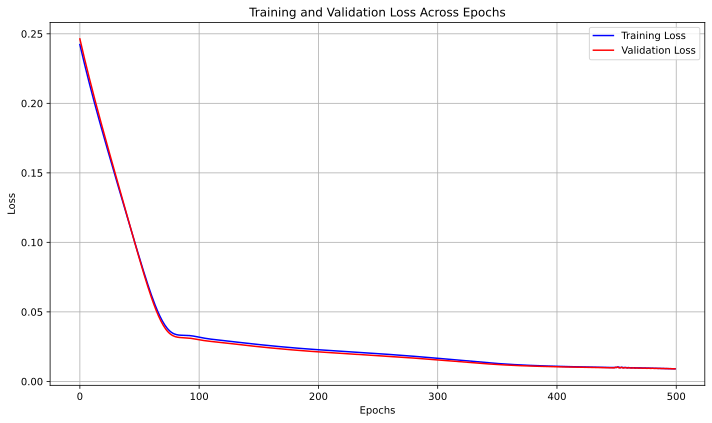

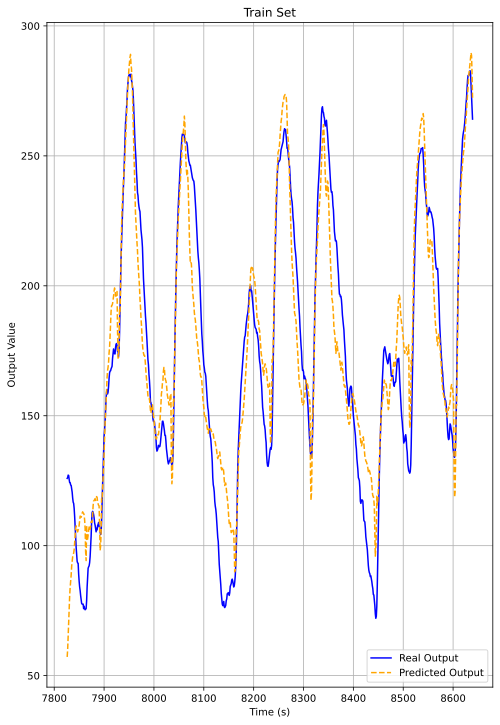

In [9]:
# --------------Plot identification results for G-----------------

#Training and Validation Loss Across Epochs
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_losses, label='Training Loss', color='blue')
plt.plot(range(epochs), val_losses, label='Validation Loss', color='red')  # Assuming val_losses are collected
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Across Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Model's Predictions vs Actual Output for the test set
fig, axes = plt.subplots(nrows=len(test_loader), ncols=1, figsize=(8, 12), sharex=True, sharey=True)
REN_0.to("cpu"); REN_1.to("cpu")

for u0_batch, _, _, u1_batch, y_batch, time in test_loader: # MH, I_rec (PID), R (noise + sat), I_sat (I_rec + R), CGM, time:
    
    u0_batch, u1_batch, y_batch= ensure_3d(u0_batch), ensure_3d(u1_batch), ensure_3d(y_batch)
    u0_batch, u1_batch, y_batch = u0_batch.to("cpu"), u1_batch.to("cpu"), y_batch.to("cpu")
    # Plot comparison between real and predicted for training set
    REN_0.eval(); REN_1.eval()

    y0_hat = REN_0(u0_batch)
    y1_hat = REN_1(u1_batch)# select the correct U
    y_hat = y0_hat - y1_hat
    
    y_batch_np = scaler_glucose.denormalize(y_batch.detach().cpu()).numpy()
    y_hat_np = scaler_glucose.denormalize(y_hat.detach().cpu()).numpy()
    


plt.plot(time, y_batch_np[0, :, 0], label="Real Output", color="blue")
plt.plot(time, y_hat_np[0, :, 0], label="Predicted Output", linestyle="--", color="orange")
plt.title(f"Train Set")
plt.xlabel("Time (s)")
plt.ylabel("Output Value")
plt.legend()
plt.grid(True)
plt.show()


In [10]:
#-----------------------------closedloop sysid of S through RENs------------------------
#--------------------------Define model for sysid---------------------------------------------
#create the REN model for S

y_init = x0


REN_0 = REN_IQC_gamma(dim_in= input_dim[0], dim_out= output_dim[0], dim_internal=dim_internal[0], dim_nl= dim_nl[0], y_init = y_init[0], QR_fun = set_QR, gammat=gamma[0], IQC_type = IQC_type[0], device=device)

REN_S = REN_IQC_gamma(dim_in= input_dim[1], dim_out= output_dim[1], dim_internal=dim_internal[1], dim_nl= dim_nl[1], y_init = y_init[1], QR_fun = set_QR, gammat=gamma[1], IQC_type = IQC_type[1], device=device)
Dual_REN = DualREN(REN_0, REN_S, device=device)
controller = NonLinearController(loaded_parameters, PID_functions, dataset.basal_vec, scaler_glucose, scaler_insulin, scaler_meal, use_noise)
closed_loop_REN = ClosedLoopSystem(Dual_REN, controller, negative=True)

closed_loop_closed_loop_1 = ClosedLoopSystem(closed_loop_REN, controller)



#--------------------------Define the loss function and optimizer---------------------------------------------
MSE = nn.MSELoss()
optimizer = torch.optim.Adam(Dual_REN.parameters(), lr=learning_rate)
optimizer.zero_grad()

In [11]:
#--------------------------5. Training---------------------------------------------------------------------


REN_0 = REN_0.to(device)
REN_S = REN_S.to(device)
Dual_Ren = Dual_REN.to(device)
controller = controller.to(device)
closed_loop_REN = closed_loop_REN.to(device)
x0 = x0.to(device)
print(f"[INFO] Training on device: {device}")

closed_loop_closed_loop_1 = closed_loop_closed_loop_1.to("cpu") # test always on cpu?
torch.set_default_dtype(torch.float32)  # default tensor dtype

train_losses = []
val_losses = []  # Store validation losses across epochs

for epoch in range(epochs):
    # ---------------- TRAINING ---------------- #
    closed_loop_REN.train()
    loss_epoch = 0.0  # Accumulate training loss


    for u0_batch, _, _, u1_batch, y_batch, _ in train_loader: # MH, I_rec (PID), R (noise + sat), I_sat (I_rec + R), CGM, time
        # u_batch.shape = batch_size   horizon   input_dim
        
        u0_batch, u1_batch, y_batch= ensure_3d(u0_batch), ensure_3d(u1_batch), ensure_3d(y_batch) # batch_size, time_horizon, input_dim
        u0_batch, u1_batch, y_batch = u0_batch.to(device), u1_batch.to(device), y_batch.to(device)
        u_batch = torch.cat((u0_batch, u1_batch), dim=2)  # concatenate along input dimension

        optimizer.zero_grad()
        
        Dual_REN.reset(); 
        # closed_loop_REN.reset() ?
        
        _, y_hat_train = closed_loop_REN(x0, u_batch)

        if torch.isnan(y_hat_train).any() or torch.isinf(y_hat_train).any():
            y_hat_train = torch.nan_to_num(y_hat_train, nan=1e5, posinf=1e5, neginf=-1e5)
            for name, param in closed_loop_REN.named_parameters():
                print(f"{name}: mean {param.data.mean()}, std {param.data.std()}")

        loss_batch = MSE(y_hat_train, y_batch)

        loss_batch.backward()

        optimizer.step()

        loss_epoch += loss_batch.item()

    loss_epoch /= len(train_loader)
    train_losses.append(loss_epoch)

    # ---------------- VALIDATION ---------------- #
    Dual_REN.eval()
    loss_val_epoch = 0.0

    with torch.no_grad():
        for u0_batch, _, _, u1_batch, y_batch, _ in val_loader: # MH, I_rec (PID), R (noise + sat), I_sat (I_rec + R), CGM, time
            # u_batch.shape = batch_size   horizon   input_dim
            
            u0_batch, u1_batch, y_batch= ensure_3d(u0_batch), ensure_3d(u1_batch), ensure_3d(y_batch) # batch_size, time_horizon, input_dim
            u_batch = torch.cat((u0_batch, u1_batch), dim=2)  # concatenate along input dimension
            u_batch, y_batch = u_batch.to(device), y_batch.to(device)
            
            Dual_REN.reset(); 

            _, y_hat_val = closed_loop_REN(x0, u_batch)
            
            loss_batch_val = MSE(y_hat_val, y_batch)

            loss_val_epoch += loss_batch_val.item()

    if epoch == 0 or loss_val_epoch < min_val_loss:
        min_val_loss = loss_val_epoch
        epoch_when_model_saved = epoch
        candidate_Dual_REN = Dual_REN

    loss_val_epoch /= len(val_loader)
    val_losses.append(loss_val_epoch)  # Store validation loss for plotting

    print(f"Epoch: {epoch + 1} \t||\t Training Loss: {loss_epoch:.6f} \t||\t Validation Loss: {loss_val_epoch:.6f}")

if redo_save:
    # model on CPU before saving
    candidate_Dual_REN_cpu = candidate_Dual_REN.to('cpu')

    # Save the best model
    # 1. Create models directory
    patient_str = "/paz_" + str(int(patient)).zfill(3)
    patient_model_folder = model_folder + "/"+ "strategy_2" + "/" + patient_str
    MODEL_PATH = Path(patient_model_folder)
    MODEL_PATH.mkdir(parents = True, exist_ok = True)
    # 2. save model state dict
    torch.save({
    'Dueal_REN_state_dict': candidate_Dual_REN_cpu.state_dict()}, MODEL_PATH / 'trained_models.pth')


    # save .mat
    np_x0 = x0.detach().cpu().numpy(); np_input_dim = np.array(input_dim); np_output_dim = np.array(output_dim); np_dim_internal =np.array(dim_internal); np_dim_nl = np.array(dim_nl)
    np_y_init = y_init.cpu().numpy(); np_gamma = gamma.cpu().numpy()
    
    # 4. Create params directory
    params_folder = Path(patient_model_folder) / "params"
    params_folder.mkdir(parents=True, exist_ok=True)
    scipy.io.savemat(params_folder / 'parameters.mat', {'train_losses': train_losses, 'val_losses': val_losses, 'epoch_when_model_saved': epoch_when_model_saved, 'x0': np_x0, 'input_dim': np_input_dim, 'output_dim': np_output_dim, 'dim_internal': np_dim_internal, 'dim_nl': np_dim_nl, 'y_init': np_y_init, 'gamma': np_gamma})

[INFO] Training on device: cpu


C:\Users\pogotar\Desktop\Dottorato\Nonlinear_system_identification_modified\Nonlinear_system_identification_diabetic_patients\env_non_lin_sys_id\Lib\site-packages\torch\utils\_device.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


Epoch: 1 	||	 Training Loss: 6.255781 	||	 Validation Loss: 5.753864


Epoch: 2 	||	 Training Loss: 5.828430 	||	 Validation Loss: 5.398789


Epoch: 3 	||	 Training Loss: 5.405190 	||	 Validation Loss: 5.266251


Epoch: 4 	||	 Training Loss: 5.135658 	||	 Validation Loss: 4.941568


Epoch: 5 	||	 Training Loss: 4.827598 	||	 Validation Loss: 4.487292


Epoch: 6 	||	 Training Loss: 4.505261 	||	 Validation Loss: 4.346509


Epoch: 7 	||	 Training Loss: 4.209766 	||	 Validation Loss: 4.285513


Epoch: 8 	||	 Training Loss: 3.912785 	||	 Validation Loss: 3.652219


Epoch: 9 	||	 Training Loss: 3.752623 	||	 Validation Loss: 3.001451


Epoch: 10 	||	 Training Loss: 3.386843 	||	 Validation Loss: 2.742405


Epoch: 11 	||	 Training Loss: 3.066003 	||	 Validation Loss: 2.825827


Epoch: 12 	||	 Training Loss: 2.879570 	||	 Validation Loss: 2.440285


Epoch: 13 	||	 Training Loss: 2.640645 	||	 Validation Loss: 2.130422


Epoch: 14 	||	 Training Loss: 2.320370 	||	 Validation Loss: 2.119136


Epoch: 15 	||	 Training Loss: 2.134765 	||	 Validation Loss: 1.913225


Epoch: 16 	||	 Training Loss: 1.861334 	||	 Validation Loss: 1.774550


Epoch: 17 	||	 Training Loss: 1.723357 	||	 Validation Loss: 1.708445


Epoch: 18 	||	 Training Loss: 1.576631 	||	 Validation Loss: 1.521967


Epoch: 19 	||	 Training Loss: 1.457802 	||	 Validation Loss: 1.381906


Epoch: 20 	||	 Training Loss: 1.340387 	||	 Validation Loss: 1.279431


Epoch: 21 	||	 Training Loss: 1.233483 	||	 Validation Loss: 1.190955


Epoch: 22 	||	 Training Loss: 1.135337 	||	 Validation Loss: 1.090068


Epoch: 23 	||	 Training Loss: 1.055053 	||	 Validation Loss: 0.975175


Epoch: 24 	||	 Training Loss: 0.968897 	||	 Validation Loss: 0.912325


Epoch: 25 	||	 Training Loss: 0.902672 	||	 Validation Loss: 0.855213


Epoch: 26 	||	 Training Loss: 0.842264 	||	 Validation Loss: 0.791707


Epoch: 27 	||	 Training Loss: 0.791815 	||	 Validation Loss: 0.752077


Epoch: 28 	||	 Training Loss: 0.738495 	||	 Validation Loss: 0.714490


Epoch: 29 	||	 Training Loss: 0.689820 	||	 Validation Loss: 0.659469


Epoch: 30 	||	 Training Loss: 0.651333 	||	 Validation Loss: 0.628975


Epoch: 31 	||	 Training Loss: 0.611845 	||	 Validation Loss: 0.599740


Epoch: 32 	||	 Training Loss: 0.581513 	||	 Validation Loss: 0.559621


Epoch: 33 	||	 Training Loss: 0.547556 	||	 Validation Loss: 0.546511


Epoch: 34 	||	 Training Loss: 0.524219 	||	 Validation Loss: 0.513101


Epoch: 35 	||	 Training Loss: 0.504003 	||	 Validation Loss: 0.498300


Epoch: 36 	||	 Training Loss: 0.482062 	||	 Validation Loss: 0.467094


Epoch: 37 	||	 Training Loss: 0.460106 	||	 Validation Loss: 0.456747


Epoch: 38 	||	 Training Loss: 0.441137 	||	 Validation Loss: 0.440649


Epoch: 39 	||	 Training Loss: 0.426017 	||	 Validation Loss: 0.414406


Epoch: 40 	||	 Training Loss: 0.408919 	||	 Validation Loss: 0.399079


Epoch: 41 	||	 Training Loss: 0.395226 	||	 Validation Loss: 0.395960


Epoch: 42 	||	 Training Loss: 0.385292 	||	 Validation Loss: 0.373822


Epoch: 43 	||	 Training Loss: 0.372026 	||	 Validation Loss: 0.368156


Epoch: 44 	||	 Training Loss: 0.356482 	||	 Validation Loss: 0.349106


Epoch: 45 	||	 Training Loss: 0.348813 	||	 Validation Loss: 0.341206


Epoch: 46 	||	 Training Loss: 0.335789 	||	 Validation Loss: 0.333745


Epoch: 47 	||	 Training Loss: 0.323147 	||	 Validation Loss: 0.317732


Epoch: 48 	||	 Training Loss: 0.314258 	||	 Validation Loss: 0.308891


Epoch: 49 	||	 Training Loss: 0.304819 	||	 Validation Loss: 0.301320


Epoch: 50 	||	 Training Loss: 0.298348 	||	 Validation Loss: 0.286154


Epoch: 51 	||	 Training Loss: 0.288896 	||	 Validation Loss: 0.283047


Epoch: 52 	||	 Training Loss: 0.281933 	||	 Validation Loss: 0.274917


Epoch: 53 	||	 Training Loss: 0.274625 	||	 Validation Loss: 0.265946


Epoch: 54 	||	 Training Loss: 0.267127 	||	 Validation Loss: 0.257424


Epoch: 55 	||	 Training Loss: 0.261310 	||	 Validation Loss: 0.254499


Epoch: 56 	||	 Training Loss: 0.252850 	||	 Validation Loss: 0.248056


Epoch: 57 	||	 Training Loss: 0.244261 	||	 Validation Loss: 0.240416


Epoch: 58 	||	 Training Loss: 0.239329 	||	 Validation Loss: 0.233082


Epoch: 59 	||	 Training Loss: 0.232374 	||	 Validation Loss: 0.225192


Epoch: 60 	||	 Training Loss: 0.226804 	||	 Validation Loss: 0.221015


Epoch: 61 	||	 Training Loss: 0.220465 	||	 Validation Loss: 0.212185


Epoch: 62 	||	 Training Loss: 0.212450 	||	 Validation Loss: 0.206555


Epoch: 63 	||	 Training Loss: 0.208006 	||	 Validation Loss: 0.202264


Epoch: 64 	||	 Training Loss: 0.202106 	||	 Validation Loss: 0.196412


Epoch: 65 	||	 Training Loss: 0.197325 	||	 Validation Loss: 0.188530


Epoch: 66 	||	 Training Loss: 0.190976 	||	 Validation Loss: 0.183916


Epoch: 67 	||	 Training Loss: 0.185431 	||	 Validation Loss: 0.180414


Epoch: 68 	||	 Training Loss: 0.178815 	||	 Validation Loss: 0.173508


Epoch: 69 	||	 Training Loss: 0.175703 	||	 Validation Loss: 0.168629


Epoch: 70 	||	 Training Loss: 0.169343 	||	 Validation Loss: 0.163857


Epoch: 71 	||	 Training Loss: 0.164811 	||	 Validation Loss: 0.154671


Epoch: 72 	||	 Training Loss: 0.160190 	||	 Validation Loss: 0.151554


Epoch: 73 	||	 Training Loss: 0.155604 	||	 Validation Loss: 0.148407


Epoch: 74 	||	 Training Loss: 0.150062 	||	 Validation Loss: 0.143457


Epoch: 75 	||	 Training Loss: 0.145545 	||	 Validation Loss: 0.140095


Epoch: 76 	||	 Training Loss: 0.141893 	||	 Validation Loss: 0.136058


Epoch: 77 	||	 Training Loss: 0.136406 	||	 Validation Loss: 0.131283


Epoch: 78 	||	 Training Loss: 0.132884 	||	 Validation Loss: 0.126505


Epoch: 79 	||	 Training Loss: 0.128274 	||	 Validation Loss: 0.123110


Epoch: 80 	||	 Training Loss: 0.124784 	||	 Validation Loss: 0.117576


Epoch: 81 	||	 Training Loss: 0.120999 	||	 Validation Loss: 0.115693


Epoch: 82 	||	 Training Loss: 0.116782 	||	 Validation Loss: 0.110563


Epoch: 83 	||	 Training Loss: 0.113056 	||	 Validation Loss: 0.108394


Epoch: 84 	||	 Training Loss: 0.110041 	||	 Validation Loss: 0.103850


Epoch: 85 	||	 Training Loss: 0.106434 	||	 Validation Loss: 0.099918


Epoch: 86 	||	 Training Loss: 0.102244 	||	 Validation Loss: 0.097987


Epoch: 87 	||	 Training Loss: 0.099200 	||	 Validation Loss: 0.093160


Epoch: 88 	||	 Training Loss: 0.095790 	||	 Validation Loss: 0.092065


Epoch: 89 	||	 Training Loss: 0.093138 	||	 Validation Loss: 0.086644


Epoch: 90 	||	 Training Loss: 0.089588 	||	 Validation Loss: 0.084504


Epoch: 91 	||	 Training Loss: 0.086641 	||	 Validation Loss: 0.083659


Epoch: 92 	||	 Training Loss: 0.083880 	||	 Validation Loss: 0.079853


Epoch: 93 	||	 Training Loss: 0.081580 	||	 Validation Loss: 0.075330


Epoch: 94 	||	 Training Loss: 0.078557 	||	 Validation Loss: 0.074172


Epoch: 95 	||	 Training Loss: 0.076618 	||	 Validation Loss: 0.071225


Epoch: 96 	||	 Training Loss: 0.073607 	||	 Validation Loss: 0.068860


Epoch: 97 	||	 Training Loss: 0.071640 	||	 Validation Loss: 0.066732


Epoch: 98 	||	 Training Loss: 0.069092 	||	 Validation Loss: 0.066008


Epoch: 99 	||	 Training Loss: 0.067417 	||	 Validation Loss: 0.062461


Epoch: 100 	||	 Training Loss: 0.065430 	||	 Validation Loss: 0.060735


Epoch: 101 	||	 Training Loss: 0.063700 	||	 Validation Loss: 0.058409


Epoch: 102 	||	 Training Loss: 0.061693 	||	 Validation Loss: 0.057880


Epoch: 103 	||	 Training Loss: 0.059871 	||	 Validation Loss: 0.056596


Epoch: 104 	||	 Training Loss: 0.058218 	||	 Validation Loss: 0.054637


Epoch: 105 	||	 Training Loss: 0.056984 	||	 Validation Loss: 0.051683


Epoch: 106 	||	 Training Loss: 0.055285 	||	 Validation Loss: 0.051301


Epoch: 107 	||	 Training Loss: 0.054004 	||	 Validation Loss: 0.049752


Epoch: 108 	||	 Training Loss: 0.052899 	||	 Validation Loss: 0.049121


Epoch: 109 	||	 Training Loss: 0.051685 	||	 Validation Loss: 0.047106


Epoch: 110 	||	 Training Loss: 0.050575 	||	 Validation Loss: 0.046616


Epoch: 111 	||	 Training Loss: 0.049561 	||	 Validation Loss: 0.045302


Epoch: 112 	||	 Training Loss: 0.048479 	||	 Validation Loss: 0.045265


Epoch: 113 	||	 Training Loss: 0.047775 	||	 Validation Loss: 0.044333


Epoch: 114 	||	 Training Loss: 0.046768 	||	 Validation Loss: 0.043484


Epoch: 115 	||	 Training Loss: 0.046253 	||	 Validation Loss: 0.042076


Epoch: 116 	||	 Training Loss: 0.045943 	||	 Validation Loss: 0.041701


Epoch: 117 	||	 Training Loss: 0.045255 	||	 Validation Loss: 0.040955


Epoch: 118 	||	 Training Loss: 0.044349 	||	 Validation Loss: 0.040675


Epoch: 119 	||	 Training Loss: 0.044005 	||	 Validation Loss: 0.039673


Epoch: 120 	||	 Training Loss: 0.043531 	||	 Validation Loss: 0.038833


Epoch: 121 	||	 Training Loss: 0.042970 	||	 Validation Loss: 0.038745


Epoch: 122 	||	 Training Loss: 0.042557 	||	 Validation Loss: 0.038067


Epoch: 123 	||	 Training Loss: 0.042077 	||	 Validation Loss: 0.037509


Epoch: 124 	||	 Training Loss: 0.041761 	||	 Validation Loss: 0.037850


Epoch: 125 	||	 Training Loss: 0.041635 	||	 Validation Loss: 0.037827


Epoch: 126 	||	 Training Loss: 0.041272 	||	 Validation Loss: 0.037431


Epoch: 127 	||	 Training Loss: 0.041022 	||	 Validation Loss: 0.037042


Epoch: 128 	||	 Training Loss: 0.040665 	||	 Validation Loss: 0.036876


Epoch: 129 	||	 Training Loss: 0.040520 	||	 Validation Loss: 0.036676


Epoch: 130 	||	 Training Loss: 0.040259 	||	 Validation Loss: 0.036539


Epoch: 131 	||	 Training Loss: 0.040097 	||	 Validation Loss: 0.035894


Epoch: 132 	||	 Training Loss: 0.039779 	||	 Validation Loss: 0.036766


Epoch: 133 	||	 Training Loss: 0.039810 	||	 Validation Loss: 0.035703


Epoch: 134 	||	 Training Loss: 0.039478 	||	 Validation Loss: 0.035211


Epoch: 135 	||	 Training Loss: 0.039503 	||	 Validation Loss: 0.035141


Epoch: 136 	||	 Training Loss: 0.039362 	||	 Validation Loss: 0.035490


Epoch: 137 	||	 Training Loss: 0.039241 	||	 Validation Loss: 0.035275


Epoch: 138 	||	 Training Loss: 0.039352 	||	 Validation Loss: 0.034629


Epoch: 139 	||	 Training Loss: 0.039122 	||	 Validation Loss: 0.034894


Epoch: 140 	||	 Training Loss: 0.038941 	||	 Validation Loss: 0.034284


Epoch: 141 	||	 Training Loss: 0.038874 	||	 Validation Loss: 0.034509


Epoch: 142 	||	 Training Loss: 0.038563 	||	 Validation Loss: 0.034362


Epoch: 143 	||	 Training Loss: 0.038789 	||	 Validation Loss: 0.034171


Epoch: 144 	||	 Training Loss: 0.038451 	||	 Validation Loss: 0.034177


Epoch: 145 	||	 Training Loss: 0.038560 	||	 Validation Loss: 0.034407


Epoch: 146 	||	 Training Loss: 0.038464 	||	 Validation Loss: 0.034211


Epoch: 147 	||	 Training Loss: 0.038295 	||	 Validation Loss: 0.034065


Epoch: 148 	||	 Training Loss: 0.038163 	||	 Validation Loss: 0.034365


Epoch: 149 	||	 Training Loss: 0.038200 	||	 Validation Loss: 0.034162


Epoch: 150 	||	 Training Loss: 0.037988 	||	 Validation Loss: 0.033678


Epoch: 151 	||	 Training Loss: 0.038023 	||	 Validation Loss: 0.034066


Epoch: 152 	||	 Training Loss: 0.037752 	||	 Validation Loss: 0.033519


Epoch: 153 	||	 Training Loss: 0.037727 	||	 Validation Loss: 0.033244


Epoch: 154 	||	 Training Loss: 0.037602 	||	 Validation Loss: 0.033432


Epoch: 155 	||	 Training Loss: 0.037480 	||	 Validation Loss: 0.033332


Epoch: 156 	||	 Training Loss: 0.037379 	||	 Validation Loss: 0.033152


Epoch: 157 	||	 Training Loss: 0.037384 	||	 Validation Loss: 0.033286


Epoch: 158 	||	 Training Loss: 0.037065 	||	 Validation Loss: 0.033317


Epoch: 159 	||	 Training Loss: 0.037013 	||	 Validation Loss: 0.033213


Epoch: 160 	||	 Training Loss: 0.037028 	||	 Validation Loss: 0.033379


Epoch: 161 	||	 Training Loss: 0.037074 	||	 Validation Loss: 0.033016


Epoch: 162 	||	 Training Loss: 0.036834 	||	 Validation Loss: 0.033110


Epoch: 163 	||	 Training Loss: 0.036824 	||	 Validation Loss: 0.033201


Epoch: 164 	||	 Training Loss: 0.036601 	||	 Validation Loss: 0.032610


Epoch: 165 	||	 Training Loss: 0.036577 	||	 Validation Loss: 0.032891


Epoch: 166 	||	 Training Loss: 0.036442 	||	 Validation Loss: 0.031870


Epoch: 167 	||	 Training Loss: 0.036259 	||	 Validation Loss: 0.032303


Epoch: 168 	||	 Training Loss: 0.036174 	||	 Validation Loss: 0.032021


Epoch: 169 	||	 Training Loss: 0.036274 	||	 Validation Loss: 0.032539


Epoch: 170 	||	 Training Loss: 0.036022 	||	 Validation Loss: 0.032384


Epoch: 171 	||	 Training Loss: 0.035846 	||	 Validation Loss: 0.031994


Epoch: 172 	||	 Training Loss: 0.035789 	||	 Validation Loss: 0.032494


Epoch: 173 	||	 Training Loss: 0.035828 	||	 Validation Loss: 0.031799


Epoch: 174 	||	 Training Loss: 0.035925 	||	 Validation Loss: 0.032521


Epoch: 175 	||	 Training Loss: 0.035829 	||	 Validation Loss: 0.031595


Epoch: 176 	||	 Training Loss: 0.035570 	||	 Validation Loss: 0.031749


Epoch: 177 	||	 Training Loss: 0.035576 	||	 Validation Loss: 0.031800


Epoch: 178 	||	 Training Loss: 0.035587 	||	 Validation Loss: 0.031894


Epoch: 179 	||	 Training Loss: 0.035268 	||	 Validation Loss: 0.031847


Epoch: 180 	||	 Training Loss: 0.035299 	||	 Validation Loss: 0.031559


Epoch: 181 	||	 Training Loss: 0.035205 	||	 Validation Loss: 0.031561


Epoch: 182 	||	 Training Loss: 0.035130 	||	 Validation Loss: 0.031552


Epoch: 183 	||	 Training Loss: 0.035060 	||	 Validation Loss: 0.031743


Epoch: 184 	||	 Training Loss: 0.035039 	||	 Validation Loss: 0.031249


Epoch: 185 	||	 Training Loss: 0.034957 	||	 Validation Loss: 0.031286


Epoch: 186 	||	 Training Loss: 0.034943 	||	 Validation Loss: 0.031463


Epoch: 187 	||	 Training Loss: 0.034792 	||	 Validation Loss: 0.031015


Epoch: 188 	||	 Training Loss: 0.034706 	||	 Validation Loss: 0.030888


Epoch: 189 	||	 Training Loss: 0.034662 	||	 Validation Loss: 0.030969


Epoch: 190 	||	 Training Loss: 0.034578 	||	 Validation Loss: 0.031030


Epoch: 191 	||	 Training Loss: 0.034592 	||	 Validation Loss: 0.031348


Epoch: 192 	||	 Training Loss: 0.034427 	||	 Validation Loss: 0.031281


Epoch: 193 	||	 Training Loss: 0.034263 	||	 Validation Loss: 0.030750


Epoch: 194 	||	 Training Loss: 0.034384 	||	 Validation Loss: 0.030430


Epoch: 195 	||	 Training Loss: 0.034308 	||	 Validation Loss: 0.030441


Epoch: 196 	||	 Training Loss: 0.034222 	||	 Validation Loss: 0.031046


Epoch: 197 	||	 Training Loss: 0.034200 	||	 Validation Loss: 0.030351


Epoch: 198 	||	 Training Loss: 0.034049 	||	 Validation Loss: 0.030518


Epoch: 199 	||	 Training Loss: 0.034046 	||	 Validation Loss: 0.030491


Epoch: 200 	||	 Training Loss: 0.033945 	||	 Validation Loss: 0.030634


Epoch: 201 	||	 Training Loss: 0.033893 	||	 Validation Loss: 0.030131


Epoch: 202 	||	 Training Loss: 0.033912 	||	 Validation Loss: 0.030517


Epoch: 203 	||	 Training Loss: 0.033777 	||	 Validation Loss: 0.030673


Epoch: 204 	||	 Training Loss: 0.033614 	||	 Validation Loss: 0.030570


Epoch: 205 	||	 Training Loss: 0.033719 	||	 Validation Loss: 0.030545


Epoch: 206 	||	 Training Loss: 0.033588 	||	 Validation Loss: 0.030518


Epoch: 207 	||	 Training Loss: 0.033597 	||	 Validation Loss: 0.030058


Epoch: 208 	||	 Training Loss: 0.033486 	||	 Validation Loss: 0.030562


Epoch: 209 	||	 Training Loss: 0.033440 	||	 Validation Loss: 0.030186


Epoch: 210 	||	 Training Loss: 0.033460 	||	 Validation Loss: 0.030635


Epoch: 211 	||	 Training Loss: 0.033282 	||	 Validation Loss: 0.030423


Epoch: 212 	||	 Training Loss: 0.033387 	||	 Validation Loss: 0.030706


Epoch: 213 	||	 Training Loss: 0.033179 	||	 Validation Loss: 0.030045


Epoch: 214 	||	 Training Loss: 0.033216 	||	 Validation Loss: 0.030353


Epoch: 215 	||	 Training Loss: 0.033171 	||	 Validation Loss: 0.030268


Epoch: 216 	||	 Training Loss: 0.033088 	||	 Validation Loss: 0.030131


Epoch: 217 	||	 Training Loss: 0.032997 	||	 Validation Loss: 0.030165


Epoch: 218 	||	 Training Loss: 0.033081 	||	 Validation Loss: 0.030267


Epoch: 219 	||	 Training Loss: 0.032912 	||	 Validation Loss: 0.029920


Epoch: 220 	||	 Training Loss: 0.032939 	||	 Validation Loss: 0.030050


Epoch: 221 	||	 Training Loss: 0.032809 	||	 Validation Loss: 0.029921


Epoch: 222 	||	 Training Loss: 0.032752 	||	 Validation Loss: 0.029724


Epoch: 223 	||	 Training Loss: 0.032859 	||	 Validation Loss: 0.029791


Epoch: 224 	||	 Training Loss: 0.032665 	||	 Validation Loss: 0.030012


Epoch: 225 	||	 Training Loss: 0.032645 	||	 Validation Loss: 0.029708


Epoch: 226 	||	 Training Loss: 0.032652 	||	 Validation Loss: 0.029483


Epoch: 227 	||	 Training Loss: 0.032570 	||	 Validation Loss: 0.029518


Epoch: 228 	||	 Training Loss: 0.032397 	||	 Validation Loss: 0.029679


Epoch: 229 	||	 Training Loss: 0.032380 	||	 Validation Loss: 0.029385


Epoch: 230 	||	 Training Loss: 0.032346 	||	 Validation Loss: 0.029257


Epoch: 231 	||	 Training Loss: 0.032272 	||	 Validation Loss: 0.029218


Epoch: 232 	||	 Training Loss: 0.032318 	||	 Validation Loss: 0.029169


Epoch: 233 	||	 Training Loss: 0.032385 	||	 Validation Loss: 0.029389


Epoch: 234 	||	 Training Loss: 0.032239 	||	 Validation Loss: 0.028972


Epoch: 235 	||	 Training Loss: 0.032229 	||	 Validation Loss: 0.029192


Epoch: 236 	||	 Training Loss: 0.032209 	||	 Validation Loss: 0.029050


Epoch: 237 	||	 Training Loss: 0.032096 	||	 Validation Loss: 0.028834


Epoch: 238 	||	 Training Loss: 0.032225 	||	 Validation Loss: 0.028733


Epoch: 239 	||	 Training Loss: 0.031916 	||	 Validation Loss: 0.028916


Epoch: 240 	||	 Training Loss: 0.031992 	||	 Validation Loss: 0.028911


Epoch: 241 	||	 Training Loss: 0.031834 	||	 Validation Loss: 0.029039


Epoch: 242 	||	 Training Loss: 0.031846 	||	 Validation Loss: 0.029122


Epoch: 243 	||	 Training Loss: 0.031790 	||	 Validation Loss: 0.028720


Epoch: 244 	||	 Training Loss: 0.031749 	||	 Validation Loss: 0.028734


Epoch: 245 	||	 Training Loss: 0.031733 	||	 Validation Loss: 0.028562


Epoch: 246 	||	 Training Loss: 0.031696 	||	 Validation Loss: 0.028456


Epoch: 247 	||	 Training Loss: 0.031636 	||	 Validation Loss: 0.028728


Epoch: 248 	||	 Training Loss: 0.031586 	||	 Validation Loss: 0.028423


Epoch: 249 	||	 Training Loss: 0.031525 	||	 Validation Loss: 0.028492


Epoch: 250 	||	 Training Loss: 0.031617 	||	 Validation Loss: 0.028448


Epoch: 251 	||	 Training Loss: 0.031456 	||	 Validation Loss: 0.028319


Epoch: 252 	||	 Training Loss: 0.031433 	||	 Validation Loss: 0.028147


Epoch: 253 	||	 Training Loss: 0.031437 	||	 Validation Loss: 0.028121


Epoch: 254 	||	 Training Loss: 0.031309 	||	 Validation Loss: 0.028204


Epoch: 255 	||	 Training Loss: 0.031369 	||	 Validation Loss: 0.028189


Epoch: 256 	||	 Training Loss: 0.031243 	||	 Validation Loss: 0.027959


Epoch: 257 	||	 Training Loss: 0.031204 	||	 Validation Loss: 0.028089


Epoch: 258 	||	 Training Loss: 0.031193 	||	 Validation Loss: 0.028081


Epoch: 259 	||	 Training Loss: 0.031113 	||	 Validation Loss: 0.028035


Epoch: 260 	||	 Training Loss: 0.031086 	||	 Validation Loss: 0.027825


Epoch: 261 	||	 Training Loss: 0.031009 	||	 Validation Loss: 0.028030


Epoch: 262 	||	 Training Loss: 0.030963 	||	 Validation Loss: 0.027959


Epoch: 263 	||	 Training Loss: 0.030947 	||	 Validation Loss: 0.027974


Epoch: 264 	||	 Training Loss: 0.031007 	||	 Validation Loss: 0.027988


Epoch: 265 	||	 Training Loss: 0.030794 	||	 Validation Loss: 0.027830


Epoch: 266 	||	 Training Loss: 0.030958 	||	 Validation Loss: 0.027853


Epoch: 267 	||	 Training Loss: 0.030850 	||	 Validation Loss: 0.027685


Epoch: 268 	||	 Training Loss: 0.030702 	||	 Validation Loss: 0.027706


Epoch: 269 	||	 Training Loss: 0.030723 	||	 Validation Loss: 0.027865


Epoch: 270 	||	 Training Loss: 0.030704 	||	 Validation Loss: 0.027333


Epoch: 271 	||	 Training Loss: 0.030714 	||	 Validation Loss: 0.027647


Epoch: 272 	||	 Training Loss: 0.030581 	||	 Validation Loss: 0.027459


Epoch: 273 	||	 Training Loss: 0.030594 	||	 Validation Loss: 0.027566


Epoch: 274 	||	 Training Loss: 0.030638 	||	 Validation Loss: 0.027519


Epoch: 275 	||	 Training Loss: 0.030544 	||	 Validation Loss: 0.027618


Epoch: 276 	||	 Training Loss: 0.030430 	||	 Validation Loss: 0.027578


Epoch: 277 	||	 Training Loss: 0.030347 	||	 Validation Loss: 0.027382


Epoch: 278 	||	 Training Loss: 0.030362 	||	 Validation Loss: 0.027402


Epoch: 279 	||	 Training Loss: 0.030262 	||	 Validation Loss: 0.027453


Epoch: 280 	||	 Training Loss: 0.030265 	||	 Validation Loss: 0.027256


Epoch: 281 	||	 Training Loss: 0.030229 	||	 Validation Loss: 0.027399


Epoch: 282 	||	 Training Loss: 0.030290 	||	 Validation Loss: 0.027363


Epoch: 283 	||	 Training Loss: 0.030158 	||	 Validation Loss: 0.027333


Epoch: 284 	||	 Training Loss: 0.030164 	||	 Validation Loss: 0.027231


Epoch: 285 	||	 Training Loss: 0.030041 	||	 Validation Loss: 0.027082


Epoch: 286 	||	 Training Loss: 0.029994 	||	 Validation Loss: 0.027295


Epoch: 287 	||	 Training Loss: 0.030077 	||	 Validation Loss: 0.027214


Epoch: 288 	||	 Training Loss: 0.029991 	||	 Validation Loss: 0.027161


Epoch: 289 	||	 Training Loss: 0.030014 	||	 Validation Loss: 0.027138


Epoch: 290 	||	 Training Loss: 0.029897 	||	 Validation Loss: 0.027260


Epoch: 291 	||	 Training Loss: 0.029902 	||	 Validation Loss: 0.026986


Epoch: 292 	||	 Training Loss: 0.029835 	||	 Validation Loss: 0.026898


Epoch: 293 	||	 Training Loss: 0.029854 	||	 Validation Loss: 0.027032


Epoch: 294 	||	 Training Loss: 0.029711 	||	 Validation Loss: 0.027022


Epoch: 295 	||	 Training Loss: 0.029621 	||	 Validation Loss: 0.026982


Epoch: 296 	||	 Training Loss: 0.029659 	||	 Validation Loss: 0.026953


Epoch: 297 	||	 Training Loss: 0.029550 	||	 Validation Loss: 0.026939


Epoch: 298 	||	 Training Loss: 0.029617 	||	 Validation Loss: 0.026827


Epoch: 299 	||	 Training Loss: 0.029558 	||	 Validation Loss: 0.026789


Epoch: 300 	||	 Training Loss: 0.029490 	||	 Validation Loss: 0.026799


Epoch: 301 	||	 Training Loss: 0.029440 	||	 Validation Loss: 0.026711


Epoch: 302 	||	 Training Loss: 0.029389 	||	 Validation Loss: 0.026936


Epoch: 303 	||	 Training Loss: 0.029429 	||	 Validation Loss: 0.026877


Epoch: 304 	||	 Training Loss: 0.029371 	||	 Validation Loss: 0.026888


Epoch: 305 	||	 Training Loss: 0.029356 	||	 Validation Loss: 0.026844


Epoch: 306 	||	 Training Loss: 0.029265 	||	 Validation Loss: 0.026727


Epoch: 307 	||	 Training Loss: 0.029344 	||	 Validation Loss: 0.026685


Epoch: 308 	||	 Training Loss: 0.029204 	||	 Validation Loss: 0.026582


Epoch: 309 	||	 Training Loss: 0.029235 	||	 Validation Loss: 0.026564


Epoch: 310 	||	 Training Loss: 0.029191 	||	 Validation Loss: 0.026674


Epoch: 311 	||	 Training Loss: 0.029112 	||	 Validation Loss: 0.026603


Epoch: 312 	||	 Training Loss: 0.029090 	||	 Validation Loss: 0.026314


Epoch: 313 	||	 Training Loss: 0.029036 	||	 Validation Loss: 0.026511


Epoch: 314 	||	 Training Loss: 0.028939 	||	 Validation Loss: 0.026584


Epoch: 315 	||	 Training Loss: 0.029003 	||	 Validation Loss: 0.026266


Epoch: 316 	||	 Training Loss: 0.028909 	||	 Validation Loss: 0.026690


Epoch: 317 	||	 Training Loss: 0.028922 	||	 Validation Loss: 0.026478


Epoch: 318 	||	 Training Loss: 0.028902 	||	 Validation Loss: 0.026485


Epoch: 319 	||	 Training Loss: 0.028898 	||	 Validation Loss: 0.026382


Epoch: 320 	||	 Training Loss: 0.028833 	||	 Validation Loss: 0.026390


Epoch: 321 	||	 Training Loss: 0.028766 	||	 Validation Loss: 0.026192


Epoch: 322 	||	 Training Loss: 0.028811 	||	 Validation Loss: 0.026369


Epoch: 323 	||	 Training Loss: 0.028774 	||	 Validation Loss: 0.026309


Epoch: 324 	||	 Training Loss: 0.028691 	||	 Validation Loss: 0.026087


Epoch: 325 	||	 Training Loss: 0.028651 	||	 Validation Loss: 0.026196


Epoch: 326 	||	 Training Loss: 0.028549 	||	 Validation Loss: 0.026097


Epoch: 327 	||	 Training Loss: 0.028612 	||	 Validation Loss: 0.026185


Epoch: 328 	||	 Training Loss: 0.028513 	||	 Validation Loss: 0.026151


Epoch: 329 	||	 Training Loss: 0.028462 	||	 Validation Loss: 0.025912


Epoch: 330 	||	 Training Loss: 0.028491 	||	 Validation Loss: 0.025874


Epoch: 331 	||	 Training Loss: 0.028500 	||	 Validation Loss: 0.025934


Epoch: 332 	||	 Training Loss: 0.028427 	||	 Validation Loss: 0.025913


Epoch: 333 	||	 Training Loss: 0.028434 	||	 Validation Loss: 0.025815


Epoch: 334 	||	 Training Loss: 0.028283 	||	 Validation Loss: 0.025840


Epoch: 335 	||	 Training Loss: 0.028316 	||	 Validation Loss: 0.025773


Epoch: 336 	||	 Training Loss: 0.028258 	||	 Validation Loss: 0.025988


Epoch: 337 	||	 Training Loss: 0.028259 	||	 Validation Loss: 0.025831


Epoch: 338 	||	 Training Loss: 0.028186 	||	 Validation Loss: 0.025710


Epoch: 339 	||	 Training Loss: 0.028173 	||	 Validation Loss: 0.025876


Epoch: 340 	||	 Training Loss: 0.028211 	||	 Validation Loss: 0.025580


Epoch: 341 	||	 Training Loss: 0.028172 	||	 Validation Loss: 0.025691


Epoch: 342 	||	 Training Loss: 0.028128 	||	 Validation Loss: 0.025637


Epoch: 343 	||	 Training Loss: 0.028094 	||	 Validation Loss: 0.025436


Epoch: 344 	||	 Training Loss: 0.028089 	||	 Validation Loss: 0.025498


Epoch: 345 	||	 Training Loss: 0.028027 	||	 Validation Loss: 0.025438


Epoch: 346 	||	 Training Loss: 0.028025 	||	 Validation Loss: 0.025459


Epoch: 347 	||	 Training Loss: 0.028016 	||	 Validation Loss: 0.025312


Epoch: 348 	||	 Training Loss: 0.027940 	||	 Validation Loss: 0.025323


Epoch: 349 	||	 Training Loss: 0.027930 	||	 Validation Loss: 0.025419


Epoch: 350 	||	 Training Loss: 0.027837 	||	 Validation Loss: 0.025305


Epoch: 351 	||	 Training Loss: 0.027827 	||	 Validation Loss: 0.025283


Epoch: 352 	||	 Training Loss: 0.027820 	||	 Validation Loss: 0.025363


Epoch: 353 	||	 Training Loss: 0.027816 	||	 Validation Loss: 0.025324


Epoch: 354 	||	 Training Loss: 0.027708 	||	 Validation Loss: 0.025296


Epoch: 355 	||	 Training Loss: 0.027675 	||	 Validation Loss: 0.025312


Epoch: 356 	||	 Training Loss: 0.027669 	||	 Validation Loss: 0.025178


Epoch: 357 	||	 Training Loss: 0.027652 	||	 Validation Loss: 0.025127


Epoch: 358 	||	 Training Loss: 0.027664 	||	 Validation Loss: 0.025218


Epoch: 359 	||	 Training Loss: 0.027644 	||	 Validation Loss: 0.025111


Epoch: 360 	||	 Training Loss: 0.027527 	||	 Validation Loss: 0.024953


Epoch: 361 	||	 Training Loss: 0.027559 	||	 Validation Loss: 0.025143


Epoch: 362 	||	 Training Loss: 0.027490 	||	 Validation Loss: 0.025022


Epoch: 363 	||	 Training Loss: 0.027490 	||	 Validation Loss: 0.025110


Epoch: 364 	||	 Training Loss: 0.027460 	||	 Validation Loss: 0.024988


Epoch: 365 	||	 Training Loss: 0.027428 	||	 Validation Loss: 0.024940


Epoch: 366 	||	 Training Loss: 0.027383 	||	 Validation Loss: 0.024782


Epoch: 367 	||	 Training Loss: 0.027339 	||	 Validation Loss: 0.024839


Epoch: 368 	||	 Training Loss: 0.027300 	||	 Validation Loss: 0.024838


Epoch: 369 	||	 Training Loss: 0.027297 	||	 Validation Loss: 0.024782


Epoch: 370 	||	 Training Loss: 0.027298 	||	 Validation Loss: 0.024813


Epoch: 371 	||	 Training Loss: 0.027221 	||	 Validation Loss: 0.024847


Epoch: 372 	||	 Training Loss: 0.027175 	||	 Validation Loss: 0.024795


Epoch: 373 	||	 Training Loss: 0.027206 	||	 Validation Loss: 0.024766


Epoch: 374 	||	 Training Loss: 0.027204 	||	 Validation Loss: 0.024896


Epoch: 375 	||	 Training Loss: 0.027173 	||	 Validation Loss: 0.024396


Epoch: 376 	||	 Training Loss: 0.027064 	||	 Validation Loss: 0.024704


Epoch: 377 	||	 Training Loss: 0.027059 	||	 Validation Loss: 0.024522


Epoch: 378 	||	 Training Loss: 0.027038 	||	 Validation Loss: 0.024689


Epoch: 379 	||	 Training Loss: 0.026969 	||	 Validation Loss: 0.024671


Epoch: 380 	||	 Training Loss: 0.026977 	||	 Validation Loss: 0.024629


Epoch: 381 	||	 Training Loss: 0.026956 	||	 Validation Loss: 0.024505


Epoch: 382 	||	 Training Loss: 0.026961 	||	 Validation Loss: 0.024427


Epoch: 383 	||	 Training Loss: 0.026928 	||	 Validation Loss: 0.024512


Epoch: 384 	||	 Training Loss: 0.026843 	||	 Validation Loss: 0.024505


Epoch: 385 	||	 Training Loss: 0.026816 	||	 Validation Loss: 0.024430


Epoch: 386 	||	 Training Loss: 0.026762 	||	 Validation Loss: 0.024533


Epoch: 387 	||	 Training Loss: 0.026751 	||	 Validation Loss: 0.024285


Epoch: 388 	||	 Training Loss: 0.026722 	||	 Validation Loss: 0.024405


Epoch: 389 	||	 Training Loss: 0.026750 	||	 Validation Loss: 0.024358


Epoch: 390 	||	 Training Loss: 0.026703 	||	 Validation Loss: 0.024307


Epoch: 391 	||	 Training Loss: 0.026702 	||	 Validation Loss: 0.024223


Epoch: 392 	||	 Training Loss: 0.026638 	||	 Validation Loss: 0.024393


Epoch: 393 	||	 Training Loss: 0.026585 	||	 Validation Loss: 0.024195


Epoch: 394 	||	 Training Loss: 0.026578 	||	 Validation Loss: 0.024042


Epoch: 395 	||	 Training Loss: 0.026529 	||	 Validation Loss: 0.024180


Epoch: 396 	||	 Training Loss: 0.026530 	||	 Validation Loss: 0.024142


Epoch: 397 	||	 Training Loss: 0.026460 	||	 Validation Loss: 0.024142


Epoch: 398 	||	 Training Loss: 0.026447 	||	 Validation Loss: 0.024069


Epoch: 399 	||	 Training Loss: 0.026435 	||	 Validation Loss: 0.024040


Epoch: 400 	||	 Training Loss: 0.026465 	||	 Validation Loss: 0.023992


Epoch: 401 	||	 Training Loss: 0.026410 	||	 Validation Loss: 0.023942


Epoch: 402 	||	 Training Loss: 0.026336 	||	 Validation Loss: 0.023885


Epoch: 403 	||	 Training Loss: 0.026323 	||	 Validation Loss: 0.023944


Epoch: 404 	||	 Training Loss: 0.026318 	||	 Validation Loss: 0.023763


Epoch: 405 	||	 Training Loss: 0.026288 	||	 Validation Loss: 0.023900


Epoch: 406 	||	 Training Loss: 0.026261 	||	 Validation Loss: 0.023860


Epoch: 407 	||	 Training Loss: 0.026216 	||	 Validation Loss: 0.023835


Epoch: 408 	||	 Training Loss: 0.026160 	||	 Validation Loss: 0.023708


Epoch: 409 	||	 Training Loss: 0.026157 	||	 Validation Loss: 0.023694


Epoch: 410 	||	 Training Loss: 0.026130 	||	 Validation Loss: 0.023703


Epoch: 411 	||	 Training Loss: 0.026112 	||	 Validation Loss: 0.023710


Epoch: 412 	||	 Training Loss: 0.026060 	||	 Validation Loss: 0.023692


Epoch: 413 	||	 Training Loss: 0.026099 	||	 Validation Loss: 0.023655


Epoch: 414 	||	 Training Loss: 0.026009 	||	 Validation Loss: 0.023480


Epoch: 415 	||	 Training Loss: 0.025988 	||	 Validation Loss: 0.023634


Epoch: 416 	||	 Training Loss: 0.025963 	||	 Validation Loss: 0.023599


Epoch: 417 	||	 Training Loss: 0.025976 	||	 Validation Loss: 0.023527


Epoch: 418 	||	 Training Loss: 0.025946 	||	 Validation Loss: 0.023528


Epoch: 419 	||	 Training Loss: 0.025928 	||	 Validation Loss: 0.023402


Epoch: 420 	||	 Training Loss: 0.025882 	||	 Validation Loss: 0.023498


Epoch: 421 	||	 Training Loss: 0.025843 	||	 Validation Loss: 0.023450


Epoch: 422 	||	 Training Loss: 0.025822 	||	 Validation Loss: 0.023419


Epoch: 423 	||	 Training Loss: 0.025811 	||	 Validation Loss: 0.023330


Epoch: 424 	||	 Training Loss: 0.025781 	||	 Validation Loss: 0.023317


Epoch: 425 	||	 Training Loss: 0.025733 	||	 Validation Loss: 0.023314


Epoch: 426 	||	 Training Loss: 0.025749 	||	 Validation Loss: 0.023348


Epoch: 427 	||	 Training Loss: 0.025695 	||	 Validation Loss: 0.023211


Epoch: 428 	||	 Training Loss: 0.025674 	||	 Validation Loss: 0.023104


Epoch: 429 	||	 Training Loss: 0.025646 	||	 Validation Loss: 0.023249


Epoch: 430 	||	 Training Loss: 0.025647 	||	 Validation Loss: 0.023130


Epoch: 431 	||	 Training Loss: 0.025575 	||	 Validation Loss: 0.023189


Epoch: 432 	||	 Training Loss: 0.025582 	||	 Validation Loss: 0.023143


Epoch: 433 	||	 Training Loss: 0.025523 	||	 Validation Loss: 0.023091


Epoch: 434 	||	 Training Loss: 0.025510 	||	 Validation Loss: 0.023080


Epoch: 435 	||	 Training Loss: 0.025469 	||	 Validation Loss: 0.022944


Epoch: 436 	||	 Training Loss: 0.025453 	||	 Validation Loss: 0.022999


Epoch: 437 	||	 Training Loss: 0.025407 	||	 Validation Loss: 0.023045


Epoch: 438 	||	 Training Loss: 0.025401 	||	 Validation Loss: 0.022978


Epoch: 439 	||	 Training Loss: 0.025373 	||	 Validation Loss: 0.022869


Epoch: 440 	||	 Training Loss: 0.025303 	||	 Validation Loss: 0.022898


Epoch: 441 	||	 Training Loss: 0.025323 	||	 Validation Loss: 0.023002


Epoch: 442 	||	 Training Loss: 0.025317 	||	 Validation Loss: 0.022969


Epoch: 443 	||	 Training Loss: 0.025218 	||	 Validation Loss: 0.022954


Epoch: 444 	||	 Training Loss: 0.025234 	||	 Validation Loss: 0.022885


Epoch: 445 	||	 Training Loss: 0.025210 	||	 Validation Loss: 0.022795


Epoch: 446 	||	 Training Loss: 0.025169 	||	 Validation Loss: 0.022848


Epoch: 447 	||	 Training Loss: 0.025153 	||	 Validation Loss: 0.022731


Epoch: 448 	||	 Training Loss: 0.025156 	||	 Validation Loss: 0.022788


Epoch: 449 	||	 Training Loss: 0.025129 	||	 Validation Loss: 0.022631


Epoch: 450 	||	 Training Loss: 0.025118 	||	 Validation Loss: 0.022597


Epoch: 451 	||	 Training Loss: 0.025088 	||	 Validation Loss: 0.022673


Epoch: 452 	||	 Training Loss: 0.024986 	||	 Validation Loss: 0.022631


Epoch: 453 	||	 Training Loss: 0.024982 	||	 Validation Loss: 0.022548


Epoch: 454 	||	 Training Loss: 0.025002 	||	 Validation Loss: 0.022523


Epoch: 455 	||	 Training Loss: 0.024974 	||	 Validation Loss: 0.022499


Epoch: 456 	||	 Training Loss: 0.024928 	||	 Validation Loss: 0.022549


Epoch: 457 	||	 Training Loss: 0.024893 	||	 Validation Loss: 0.022525


Epoch: 458 	||	 Training Loss: 0.024890 	||	 Validation Loss: 0.022450


Epoch: 459 	||	 Training Loss: 0.024873 	||	 Validation Loss: 0.022437


Epoch: 460 	||	 Training Loss: 0.024863 	||	 Validation Loss: 0.022541


Epoch: 461 	||	 Training Loss: 0.024813 	||	 Validation Loss: 0.022301


Epoch: 462 	||	 Training Loss: 0.024779 	||	 Validation Loss: 0.022382


Epoch: 463 	||	 Training Loss: 0.024778 	||	 Validation Loss: 0.022294


Epoch: 464 	||	 Training Loss: 0.024715 	||	 Validation Loss: 0.022293


Epoch: 465 	||	 Training Loss: 0.024684 	||	 Validation Loss: 0.022321


Epoch: 466 	||	 Training Loss: 0.024700 	||	 Validation Loss: 0.022219


Epoch: 467 	||	 Training Loss: 0.024700 	||	 Validation Loss: 0.022170


Epoch: 468 	||	 Training Loss: 0.024601 	||	 Validation Loss: 0.022147


Epoch: 469 	||	 Training Loss: 0.024594 	||	 Validation Loss: 0.022145


Epoch: 470 	||	 Training Loss: 0.024593 	||	 Validation Loss: 0.022189


Epoch: 471 	||	 Training Loss: 0.024546 	||	 Validation Loss: 0.022102


Epoch: 472 	||	 Training Loss: 0.024522 	||	 Validation Loss: 0.022080


Epoch: 473 	||	 Training Loss: 0.024517 	||	 Validation Loss: 0.022312


Epoch: 474 	||	 Training Loss: 0.024501 	||	 Validation Loss: 0.022107


Epoch: 475 	||	 Training Loss: 0.024453 	||	 Validation Loss: 0.021983


Epoch: 476 	||	 Training Loss: 0.024403 	||	 Validation Loss: 0.022018


Epoch: 477 	||	 Training Loss: 0.024422 	||	 Validation Loss: 0.021946


Epoch: 478 	||	 Training Loss: 0.024380 	||	 Validation Loss: 0.022018


Epoch: 479 	||	 Training Loss: 0.024364 	||	 Validation Loss: 0.021988


Epoch: 480 	||	 Training Loss: 0.024368 	||	 Validation Loss: 0.021932


Epoch: 481 	||	 Training Loss: 0.024322 	||	 Validation Loss: 0.021967


Epoch: 482 	||	 Training Loss: 0.024256 	||	 Validation Loss: 0.022023


Epoch: 483 	||	 Training Loss: 0.024236 	||	 Validation Loss: 0.021909


Epoch: 484 	||	 Training Loss: 0.024223 	||	 Validation Loss: 0.021811


Epoch: 485 	||	 Training Loss: 0.024194 	||	 Validation Loss: 0.021774


Epoch: 486 	||	 Training Loss: 0.024225 	||	 Validation Loss: 0.021816


Epoch: 487 	||	 Training Loss: 0.024156 	||	 Validation Loss: 0.021870


Epoch: 488 	||	 Training Loss: 0.024132 	||	 Validation Loss: 0.021789


Epoch: 489 	||	 Training Loss: 0.024117 	||	 Validation Loss: 0.021712


Epoch: 490 	||	 Training Loss: 0.024064 	||	 Validation Loss: 0.021699


Epoch: 491 	||	 Training Loss: 0.024063 	||	 Validation Loss: 0.021698


Epoch: 492 	||	 Training Loss: 0.024043 	||	 Validation Loss: 0.021721


Epoch: 493 	||	 Training Loss: 0.024035 	||	 Validation Loss: 0.021751


Epoch: 494 	||	 Training Loss: 0.024021 	||	 Validation Loss: 0.021736


Epoch: 495 	||	 Training Loss: 0.023956 	||	 Validation Loss: 0.021627


Epoch: 496 	||	 Training Loss: 0.023954 	||	 Validation Loss: 0.021679


Epoch: 497 	||	 Training Loss: 0.023916 	||	 Validation Loss: 0.021629


Epoch: 498 	||	 Training Loss: 0.023871 	||	 Validation Loss: 0.021609


Epoch: 499 	||	 Training Loss: 0.023849 	||	 Validation Loss: 0.021593


Epoch: 500 	||	 Training Loss: 0.023872 	||	 Validation Loss: 0.021476


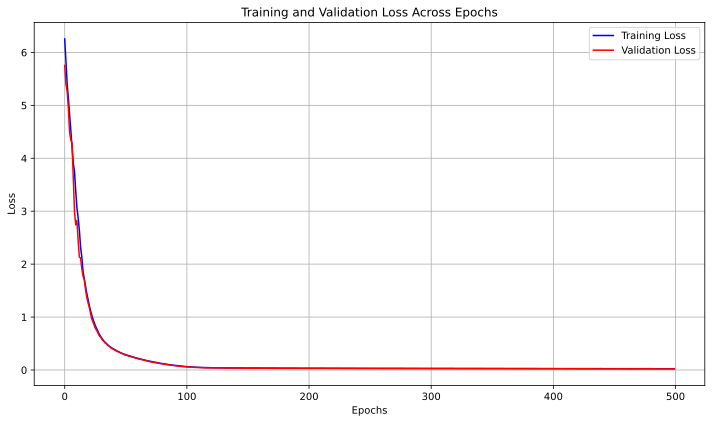

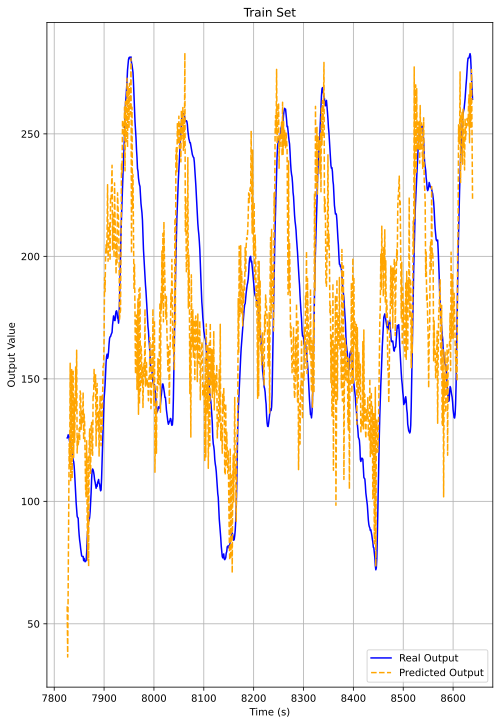

In [12]:
# --------------Plot identification results for S-----------------

#Training and Validation Loss Across Epochs
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_losses, label='Training Loss', color='blue')
plt.plot(range(epochs), val_losses, label='Validation Loss', color='red')  # Assuming val_losses are collected
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Across Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Model's Predictions vs Actual Output for the test set
fig, axes = plt.subplots(nrows=len(test_loader), ncols=1, figsize=(8, 12), sharex=True, sharey=True)

Dual_REN.to("cpu"); closed_loop_REN.to("cpu")
    

for u0_batch, _, _, u1_batch, y_batch, time in test_loader: # MH, I_rec (PID), R (noise + sat), I_sat (I_rec + R), CGM, time
    # u_batch.shape = batch_size   horizon   input_dim
    
    u0_batch, u1_batch, y_batch= ensure_3d(u0_batch), ensure_3d(u1_batch), ensure_3d(y_batch) # batch_size, time_horizon, input_dim
    u_batch = torch.cat((u0_batch, u1_batch), dim=2)  # concatenate along input dimension
    u_batch, y_batch = u_batch.to("cpu"), y_batch.to("cpu")
    

    Dual_REN.eval()
    _, y_hat = closed_loop_REN(x0, u_batch)
    
    loss_batch_val = MSE(y_batch, y_hat)

    loss_val_epoch += loss_batch_val.item()
    
    y_batch_np = scaler_glucose.denormalize(y_batch.detach().cpu()).numpy()
    y_hat_np = scaler_glucose.denormalize(y_hat.detach().cpu()).numpy()
    


plt.plot(time, y_batch_np[0, :, 0], label="Real Output", color="blue")
plt.plot(time, y_hat_np[0, :, 0], label="Predicted Output", linestyle="--", color="orange")
plt.title(f"Train Set")
plt.xlabel("Time (s)")
plt.ylabel("Output Value")
plt.legend()
plt.grid(True)
plt.show()

In [13]:
#-----------------------------closedloop sysid of S through RENs------------------------
#--------------------------Define model for sysid---------------------------------------------
#create the REN model for S
y_init = x0

REN_0 = REN_IQC_gamma(dim_in= input_dim[0], dim_out= output_dim[0], dim_internal=dim_internal[0], dim_nl= dim_nl[0], y_init = y_init[0], QR_fun = set_QR, gammat=gamma[0], IQC_type = IQC_type[0], device=device)

REN_S_2 = REN_IQC_gamma(dim_in= input_dim[1], dim_out= output_dim[1], dim_internal=dim_internal[1], dim_nl= dim_nl[1], y_init = y_init[1], QR_fun = set_QR, gammat=gamma[1], IQC_type = IQC_type[1], device=device)


#--------------------------Define the loss function and optimizer---------------------------------------------
MSE = nn.MSELoss()
optimizer = torch.optim.Adam( list(REN_0.parameters()) + list(REN_S_2.parameters()),   lr=learning_rate)
optimizer.zero_grad()

In [14]:
#--------------------------5. Training---------------------------------------------------------------------

REN_0 = REN_0.to(device)
REN_S_2 = REN_S_2.to(device)
print(f"[INFO] Training on device: {device}")

torch.set_default_dtype(torch.float32)  # default tensor dtype

train_losses = []
val_losses = []  # Store validation losses across epochs


for epoch in range(epochs):
    # ---------------- TRAINING ---------------- #
    REN_0.train(); REN_S_2.train()
    loss_epoch = 0.0  # Accumulate training loss

    for u0_batch, _, u1_batch, _, y_batch, _ in train_loader: # MH, I_rec (PID), R (noise + sat), I_sat (I_rec + R), CGM, time
        # u_batch.shape = batch_size   horizon   input_dim
        u0_batch, u1_batch, y_batch = ensure_3d(u0_batch), ensure_3d(u1_batch), ensure_3d(y_batch) # batch_size, time_horizon, input_dim
        u0_batch, u1_batch, y_batch = u0_batch.to(device), u1_batch.to(device), y_batch.to(device)


        optimizer.zero_grad()
        REN_0.reset(); REN_S_2.reset()
        
        
        y0_hat_train = REN_0(u0_batch) # forward
        y1_hat_train = REN_S_2(u1_batch) # forward
        y_hat_train = y0_hat_train - y1_hat_train 
        # with monotonicity we have forced a positive response from the insulin REN (REN_1) 
        # but from real-world knowledge it is a negative relation

        loss_batch = MSE(y_hat_train, y_batch)
        
        loss_batch.backward()
        optimizer.step()

        loss_epoch += loss_batch.item()

    loss_epoch /= len(train_loader)
    train_losses.append(loss_epoch)

    # ---------------- VALIDATION ---------------- #
    REN_0.eval(); REN_S_2.eval()
    loss_val_epoch = 0.0

    with torch.no_grad():
        for u0_batch, _, u1_batch, _, y_batch, _ in val_loader: # MH, I_rec (PID), R (noise + sat), I_sat (I_rec + R), CGM, time
            # u_batch.shape = batch_size   horizon   input_dim
            
            u0_batch, u1_batch, y_batch= ensure_3d(u0_batch), ensure_3d(u1_batch), ensure_3d(y_batch) # batch_size, time_horizon, input_dim
            u0_batch, u1_batch, y_batch = u0_batch.to(device), u1_batch.to(device), y_batch.to(device)
            
            REN_0.reset(); REN_S_2.reset()
            
            y0_hat_val = REN_0(u0_batch) # forward
            y1_hat_val = REN_S_2(u1_batch) # forward
            y_hat_val = y0_hat_val - y1_hat_val
            
            loss_batch_val = MSE(y_hat_val, y_batch)

            loss_val_epoch += loss_batch_val.item()

    if epoch == 0 or loss_val_epoch < min_val_loss:
        min_val_loss = loss_val_epoch
        epoch_when_model_saved = epoch
        candidate_REN_0 = REN_0
        candidate_REN_S_2 = REN_S_2

    loss_val_epoch /= len(val_loader)
    val_losses.append(loss_val_epoch)  # Store validation loss for plotting

    print(f"Epoch: {epoch + 1} \t||\t Training Loss: {loss_epoch:.6f} \t||\t Validation Loss: {loss_val_epoch:.6f}")

if redo_save:
    # model on CPU before saving
    candidate_REN_0_cpu = candidate_REN_0.to('cpu')
    candidate_REN_S_2_cpu = candidate_REN_S_2.to('cpu')

    # Save the best model
    # 1. Create models directory
    patient_str = "/paz_" + str(int(patient)).zfill(3)
    patient_model_folder = model_folder + "/"+ "strategy_3" + "/" + patient_str
    MODEL_PATH = Path(patient_model_folder)
    MODEL_PATH.mkdir(parents = True, exist_ok = True)
    # 2. save model state dict
    torch.save({
    'REN_0_state_dict': candidate_REN_0_cpu.state_dict(),
    'REN_S_2_state_dict': candidate_REN_S_2_cpu.state_dict()}, MODEL_PATH / 'trained_models.pth')


    # save .mat
    np_x0 = x0.detach().cpu().numpy(); np_input_dim = np.array(input_dim); np_output_dim = np.array(output_dim); np_dim_internal =np.array(dim_internal); np_dim_nl = np.array(dim_nl)
    np_y_init = y_init.cpu().numpy(); np_gamma = gamma.cpu().numpy()
    
    # 4. Create params directory
    params_folder = Path(patient_model_folder) / "params"
    params_folder.mkdir(parents=True, exist_ok=True)
    scipy.io.savemat(params_folder / 'parameters.mat', {'train_losses': train_losses, 'val_losses': val_losses, 'epoch_when_model_saved': epoch_when_model_saved, 'x0': np_x0, 'input_dim': np_input_dim, 'output_dim': np_output_dim, 'dim_internal': np_dim_internal, 'dim_nl': np_dim_nl, 'y_init': np_y_init, 'gamma': np_gamma})
    
Dual_REN = DualREN(candidate_REN_0_cpu, candidate_REN_S_2_cpu)
controller = NonLinearController(loaded_parameters, PID_functions, dataset.basal_vec, scaler_glucose, scaler_insulin, scaler_meal, use_noise)
closed_loop_REN_2 = ClosedLoopSystem(Dual_REN, controller, negative=True)

closed_loop_closed_loop_2 = ClosedLoopSystem(closed_loop_REN_2, controller)

[INFO] Training on device: cpu


Epoch: 1 	||	 Training Loss: 0.274364 	||	 Validation Loss: 0.283749


Epoch: 2 	||	 Training Loss: 0.273882 	||	 Validation Loss: 0.283289


Epoch: 3 	||	 Training Loss: 0.273425 	||	 Validation Loss: 0.282852


Epoch: 4 	||	 Training Loss: 0.272990 	||	 Validation Loss: 0.282437


Epoch: 5 	||	 Training Loss: 0.272577 	||	 Validation Loss: 0.282041


Epoch: 6 	||	 Training Loss: 0.272184 	||	 Validation Loss: 0.281663


Epoch: 7 	||	 Training Loss: 0.271809 	||	 Validation Loss: 0.281302


Epoch: 8 	||	 Training Loss: 0.271451 	||	 Validation Loss: 0.280956


Epoch: 9 	||	 Training Loss: 0.271109 	||	 Validation Loss: 0.280625


Epoch: 10 	||	 Training Loss: 0.270782 	||	 Validation Loss: 0.280308


Epoch: 11 	||	 Training Loss: 0.270468 	||	 Validation Loss: 0.280002


Epoch: 12 	||	 Training Loss: 0.270166 	||	 Validation Loss: 0.279706


Epoch: 13 	||	 Training Loss: 0.269874 	||	 Validation Loss: 0.279421


Epoch: 14 	||	 Training Loss: 0.269593 	||	 Validation Loss: 0.279144


Epoch: 15 	||	 Training Loss: 0.269321 	||	 Validation Loss: 0.278876


Epoch: 16 	||	 Training Loss: 0.269056 	||	 Validation Loss: 0.278615


Epoch: 17 	||	 Training Loss: 0.268799 	||	 Validation Loss: 0.278361


Epoch: 18 	||	 Training Loss: 0.268549 	||	 Validation Loss: 0.278113


Epoch: 19 	||	 Training Loss: 0.268305 	||	 Validation Loss: 0.277870


Epoch: 20 	||	 Training Loss: 0.268067 	||	 Validation Loss: 0.277633


Epoch: 21 	||	 Training Loss: 0.267833 	||	 Validation Loss: 0.277400


Epoch: 22 	||	 Training Loss: 0.267604 	||	 Validation Loss: 0.277172


Epoch: 23 	||	 Training Loss: 0.267379 	||	 Validation Loss: 0.276947


Epoch: 24 	||	 Training Loss: 0.267158 	||	 Validation Loss: 0.276725


Epoch: 25 	||	 Training Loss: 0.266941 	||	 Validation Loss: 0.276507


Epoch: 26 	||	 Training Loss: 0.266726 	||	 Validation Loss: 0.276292


Epoch: 27 	||	 Training Loss: 0.266515 	||	 Validation Loss: 0.276080


Epoch: 28 	||	 Training Loss: 0.266306 	||	 Validation Loss: 0.275869


Epoch: 29 	||	 Training Loss: 0.266099 	||	 Validation Loss: 0.275661


Epoch: 30 	||	 Training Loss: 0.265894 	||	 Validation Loss: 0.275456


Epoch: 31 	||	 Training Loss: 0.265692 	||	 Validation Loss: 0.275251


Epoch: 32 	||	 Training Loss: 0.265491 	||	 Validation Loss: 0.275049


Epoch: 33 	||	 Training Loss: 0.265291 	||	 Validation Loss: 0.274848


Epoch: 34 	||	 Training Loss: 0.265093 	||	 Validation Loss: 0.274648


Epoch: 35 	||	 Training Loss: 0.264896 	||	 Validation Loss: 0.274449


Epoch: 36 	||	 Training Loss: 0.264700 	||	 Validation Loss: 0.274251


Epoch: 37 	||	 Training Loss: 0.264505 	||	 Validation Loss: 0.274054


Epoch: 38 	||	 Training Loss: 0.264311 	||	 Validation Loss: 0.273857


Epoch: 39 	||	 Training Loss: 0.264117 	||	 Validation Loss: 0.273661


Epoch: 40 	||	 Training Loss: 0.263924 	||	 Validation Loss: 0.273465


Epoch: 41 	||	 Training Loss: 0.263730 	||	 Validation Loss: 0.273270


Epoch: 42 	||	 Training Loss: 0.263537 	||	 Validation Loss: 0.273074


Epoch: 43 	||	 Training Loss: 0.263344 	||	 Validation Loss: 0.272878


Epoch: 44 	||	 Training Loss: 0.263150 	||	 Validation Loss: 0.272681


Epoch: 45 	||	 Training Loss: 0.262955 	||	 Validation Loss: 0.272483


Epoch: 46 	||	 Training Loss: 0.262760 	||	 Validation Loss: 0.272285


Epoch: 47 	||	 Training Loss: 0.262564 	||	 Validation Loss: 0.272086


Epoch: 48 	||	 Training Loss: 0.262366 	||	 Validation Loss: 0.271885


Epoch: 49 	||	 Training Loss: 0.262167 	||	 Validation Loss: 0.271682


Epoch: 50 	||	 Training Loss: 0.261966 	||	 Validation Loss: 0.271477


Epoch: 51 	||	 Training Loss: 0.261763 	||	 Validation Loss: 0.271270


Epoch: 52 	||	 Training Loss: 0.261558 	||	 Validation Loss: 0.271060


Epoch: 53 	||	 Training Loss: 0.261349 	||	 Validation Loss: 0.270847


Epoch: 54 	||	 Training Loss: 0.261138 	||	 Validation Loss: 0.270630


Epoch: 55 	||	 Training Loss: 0.260922 	||	 Validation Loss: 0.270409


Epoch: 56 	||	 Training Loss: 0.260703 	||	 Validation Loss: 0.270184


Epoch: 57 	||	 Training Loss: 0.260478 	||	 Validation Loss: 0.269953


Epoch: 58 	||	 Training Loss: 0.260249 	||	 Validation Loss: 0.269717


Epoch: 59 	||	 Training Loss: 0.260013 	||	 Validation Loss: 0.269474


Epoch: 60 	||	 Training Loss: 0.259771 	||	 Validation Loss: 0.269224


Epoch: 61 	||	 Training Loss: 0.259522 	||	 Validation Loss: 0.268967


Epoch: 62 	||	 Training Loss: 0.259264 	||	 Validation Loss: 0.268700


Epoch: 63 	||	 Training Loss: 0.258998 	||	 Validation Loss: 0.268424


Epoch: 64 	||	 Training Loss: 0.258721 	||	 Validation Loss: 0.268136


Epoch: 65 	||	 Training Loss: 0.258433 	||	 Validation Loss: 0.267837


Epoch: 66 	||	 Training Loss: 0.258132 	||	 Validation Loss: 0.267524


Epoch: 67 	||	 Training Loss: 0.257818 	||	 Validation Loss: 0.267196


Epoch: 68 	||	 Training Loss: 0.257488 	||	 Validation Loss: 0.266851


Epoch: 69 	||	 Training Loss: 0.257142 	||	 Validation Loss: 0.266488


Epoch: 70 	||	 Training Loss: 0.256776 	||	 Validation Loss: 0.266104


Epoch: 71 	||	 Training Loss: 0.256388 	||	 Validation Loss: 0.265698


Epoch: 72 	||	 Training Loss: 0.255978 	||	 Validation Loss: 0.265266


Epoch: 73 	||	 Training Loss: 0.255541 	||	 Validation Loss: 0.264805


Epoch: 74 	||	 Training Loss: 0.255074 	||	 Validation Loss: 0.264313


Epoch: 75 	||	 Training Loss: 0.254575 	||	 Validation Loss: 0.263786


Epoch: 76 	||	 Training Loss: 0.254040 	||	 Validation Loss: 0.263219


Epoch: 77 	||	 Training Loss: 0.253463 	||	 Validation Loss: 0.262608


Epoch: 78 	||	 Training Loss: 0.252840 	||	 Validation Loss: 0.261947


Epoch: 79 	||	 Training Loss: 0.252166 	||	 Validation Loss: 0.261231


Epoch: 80 	||	 Training Loss: 0.251434 	||	 Validation Loss: 0.260453


Epoch: 81 	||	 Training Loss: 0.250637 	||	 Validation Loss: 0.259605


Epoch: 82 	||	 Training Loss: 0.249766 	||	 Validation Loss: 0.258679


Epoch: 83 	||	 Training Loss: 0.248813 	||	 Validation Loss: 0.257666


Epoch: 84 	||	 Training Loss: 0.247766 	||	 Validation Loss: 0.256556


Epoch: 85 	||	 Training Loss: 0.246615 	||	 Validation Loss: 0.255339


Epoch: 86 	||	 Training Loss: 0.245345 	||	 Validation Loss: 0.254002


Epoch: 87 	||	 Training Loss: 0.243942 	||	 Validation Loss: 0.252533


Epoch: 88 	||	 Training Loss: 0.242389 	||	 Validation Loss: 0.250919


Epoch: 89 	||	 Training Loss: 0.240669 	||	 Validation Loss: 0.249147


Epoch: 90 	||	 Training Loss: 0.238760 	||	 Validation Loss: 0.247203


Epoch: 91 	||	 Training Loss: 0.236641 	||	 Validation Loss: 0.245071


Epoch: 92 	||	 Training Loss: 0.234285 	||	 Validation Loss: 0.242731


Epoch: 93 	||	 Training Loss: 0.231662 	||	 Validation Loss: 0.240160


Epoch: 94 	||	 Training Loss: 0.228735 	||	 Validation Loss: 0.237325


Epoch: 95 	||	 Training Loss: 0.225458 	||	 Validation Loss: 0.234178


Epoch: 96 	||	 Training Loss: 0.221773 	||	 Validation Loss: 0.230658


Epoch: 97 	||	 Training Loss: 0.217607 	||	 Validation Loss: 0.226686


Epoch: 98 	||	 Training Loss: 0.212872 	||	 Validation Loss: 0.222172


Epoch: 99 	||	 Training Loss: 0.207465 	||	 Validation Loss: 0.217027


Epoch: 100 	||	 Training Loss: 0.201278 	||	 Validation Loss: 0.211176


Epoch: 101 	||	 Training Loss: 0.194210 	||	 Validation Loss: 0.204586


Epoch: 102 	||	 Training Loss: 0.186193 	||	 Validation Loss: 0.197336


Epoch: 103 	||	 Training Loss: 0.177265 	||	 Validation Loss: 0.189692


Epoch: 104 	||	 Training Loss: 0.167664 	||	 Validation Loss: 0.182140


Epoch: 105 	||	 Training Loss: 0.157865 	||	 Validation Loss: 0.175269


Epoch: 106 	||	 Training Loss: 0.148438 	||	 Validation Loss: 0.169549


Epoch: 107 	||	 Training Loss: 0.139799 	||	 Validation Loss: 0.165180


Epoch: 108 	||	 Training Loss: 0.132025 	||	 Validation Loss: 0.162036


Epoch: 109 	||	 Training Loss: 0.124828 	||	 Validation Loss: 0.159816


Epoch: 110 	||	 Training Loss: 0.117745 	||	 Validation Loss: 0.158226


Epoch: 111 	||	 Training Loss: 0.110435 	||	 Validation Loss: 0.157038


Epoch: 112 	||	 Training Loss: 0.102835 	||	 Validation Loss: 0.156140


Epoch: 113 	||	 Training Loss: 0.095033 	||	 Validation Loss: 0.155538


Epoch: 114 	||	 Training Loss: 0.087178 	||	 Validation Loss: 0.155180


Epoch: 115 	||	 Training Loss: 0.079558 	||	 Validation Loss: 0.154910


Epoch: 116 	||	 Training Loss: 0.072640 	||	 Validation Loss: 0.154332


Epoch: 117 	||	 Training Loss: 0.067188 	||	 Validation Loss: 0.152996


Epoch: 118 	||	 Training Loss: 0.063723 	||	 Validation Loss: 0.150857


Epoch: 119 	||	 Training Loss: 0.061928 	||	 Validation Loss: 0.148203


Epoch: 120 	||	 Training Loss: 0.061129 	||	 Validation Loss: 0.145326


Epoch: 121 	||	 Training Loss: 0.060757 	||	 Validation Loss: 0.142391


Epoch: 122 	||	 Training Loss: 0.060458 	||	 Validation Loss: 0.139491


Epoch: 123 	||	 Training Loss: 0.059970 	||	 Validation Loss: 0.136722


Epoch: 124 	||	 Training Loss: 0.059091 	||	 Validation Loss: 0.134146


Epoch: 125 	||	 Training Loss: 0.057726 	||	 Validation Loss: 0.131760


Epoch: 126 	||	 Training Loss: 0.055937 	||	 Validation Loss: 0.129523


Epoch: 127 	||	 Training Loss: 0.053893 	||	 Validation Loss: 0.127359


Epoch: 128 	||	 Training Loss: 0.051817 	||	 Validation Loss: 0.125191


Epoch: 129 	||	 Training Loss: 0.049901 	||	 Validation Loss: 0.122956


Epoch: 130 	||	 Training Loss: 0.048262 	||	 Validation Loss: 0.120604


Epoch: 131 	||	 Training Loss: 0.046937 	||	 Validation Loss: 0.118126


Epoch: 132 	||	 Training Loss: 0.045883 	||	 Validation Loss: 0.115540


Epoch: 133 	||	 Training Loss: 0.045032 	||	 Validation Loss: 0.112884


Epoch: 134 	||	 Training Loss: 0.044315 	||	 Validation Loss: 0.110204


Epoch: 135 	||	 Training Loss: 0.043682 	||	 Validation Loss: 0.107546


Epoch: 136 	||	 Training Loss: 0.043102 	||	 Validation Loss: 0.104944


Epoch: 137 	||	 Training Loss: 0.042558 	||	 Validation Loss: 0.102436


Epoch: 138 	||	 Training Loss: 0.042040 	||	 Validation Loss: 0.100043


Epoch: 139 	||	 Training Loss: 0.041544 	||	 Validation Loss: 0.097786


Epoch: 140 	||	 Training Loss: 0.041068 	||	 Validation Loss: 0.095676


Epoch: 141 	||	 Training Loss: 0.040610 	||	 Validation Loss: 0.093719


Epoch: 142 	||	 Training Loss: 0.040169 	||	 Validation Loss: 0.091911


Epoch: 143 	||	 Training Loss: 0.039745 	||	 Validation Loss: 0.090247


Epoch: 144 	||	 Training Loss: 0.039338 	||	 Validation Loss: 0.088718


Epoch: 145 	||	 Training Loss: 0.038947 	||	 Validation Loss: 0.087307


Epoch: 146 	||	 Training Loss: 0.038573 	||	 Validation Loss: 0.085999


Epoch: 147 	||	 Training Loss: 0.038217 	||	 Validation Loss: 0.084781


Epoch: 148 	||	 Training Loss: 0.037878 	||	 Validation Loss: 0.083637


Epoch: 149 	||	 Training Loss: 0.037557 	||	 Validation Loss: 0.082556


Epoch: 150 	||	 Training Loss: 0.037253 	||	 Validation Loss: 0.081531


Epoch: 151 	||	 Training Loss: 0.036965 	||	 Validation Loss: 0.080553


Epoch: 152 	||	 Training Loss: 0.036694 	||	 Validation Loss: 0.079618


Epoch: 153 	||	 Training Loss: 0.036438 	||	 Validation Loss: 0.078722


Epoch: 154 	||	 Training Loss: 0.036196 	||	 Validation Loss: 0.077863


Epoch: 155 	||	 Training Loss: 0.035967 	||	 Validation Loss: 0.077038


Epoch: 156 	||	 Training Loss: 0.035751 	||	 Validation Loss: 0.076246


Epoch: 157 	||	 Training Loss: 0.035545 	||	 Validation Loss: 0.075488


Epoch: 158 	||	 Training Loss: 0.035350 	||	 Validation Loss: 0.074756


Epoch: 159 	||	 Training Loss: 0.035164 	||	 Validation Loss: 0.074050


Epoch: 160 	||	 Training Loss: 0.034986 	||	 Validation Loss: 0.073362


Epoch: 161 	||	 Training Loss: 0.034817 	||	 Validation Loss: 0.072695


Epoch: 162 	||	 Training Loss: 0.034655 	||	 Validation Loss: 0.072041


Epoch: 163 	||	 Training Loss: 0.034499 	||	 Validation Loss: 0.071395


Epoch: 164 	||	 Training Loss: 0.034350 	||	 Validation Loss: 0.070757


Epoch: 165 	||	 Training Loss: 0.034207 	||	 Validation Loss: 0.070128


Epoch: 166 	||	 Training Loss: 0.034068 	||	 Validation Loss: 0.069505


Epoch: 167 	||	 Training Loss: 0.033935 	||	 Validation Loss: 0.068894


Epoch: 168 	||	 Training Loss: 0.033807 	||	 Validation Loss: 0.068292


Epoch: 169 	||	 Training Loss: 0.033683 	||	 Validation Loss: 0.067704


Epoch: 170 	||	 Training Loss: 0.033563 	||	 Validation Loss: 0.067133


Epoch: 171 	||	 Training Loss: 0.033447 	||	 Validation Loss: 0.066578


Epoch: 172 	||	 Training Loss: 0.033334 	||	 Validation Loss: 0.066044


Epoch: 173 	||	 Training Loss: 0.033225 	||	 Validation Loss: 0.065529


Epoch: 174 	||	 Training Loss: 0.033119 	||	 Validation Loss: 0.065031


Epoch: 175 	||	 Training Loss: 0.033016 	||	 Validation Loss: 0.064545


Epoch: 176 	||	 Training Loss: 0.032916 	||	 Validation Loss: 0.064072


Epoch: 177 	||	 Training Loss: 0.032818 	||	 Validation Loss: 0.063605


Epoch: 178 	||	 Training Loss: 0.032723 	||	 Validation Loss: 0.063142


Epoch: 179 	||	 Training Loss: 0.032630 	||	 Validation Loss: 0.062680


Epoch: 180 	||	 Training Loss: 0.032539 	||	 Validation Loss: 0.062220


Epoch: 181 	||	 Training Loss: 0.032451 	||	 Validation Loss: 0.061758


Epoch: 182 	||	 Training Loss: 0.032364 	||	 Validation Loss: 0.061297


Epoch: 183 	||	 Training Loss: 0.032279 	||	 Validation Loss: 0.060839


Epoch: 184 	||	 Training Loss: 0.032196 	||	 Validation Loss: 0.060386


Epoch: 185 	||	 Training Loss: 0.032115 	||	 Validation Loss: 0.059940


Epoch: 186 	||	 Training Loss: 0.032035 	||	 Validation Loss: 0.059500


Epoch: 187 	||	 Training Loss: 0.031957 	||	 Validation Loss: 0.059066


Epoch: 188 	||	 Training Loss: 0.031880 	||	 Validation Loss: 0.058639


Epoch: 189 	||	 Training Loss: 0.031804 	||	 Validation Loss: 0.058215


Epoch: 190 	||	 Training Loss: 0.031730 	||	 Validation Loss: 0.057794


Epoch: 191 	||	 Training Loss: 0.031657 	||	 Validation Loss: 0.057373


Epoch: 192 	||	 Training Loss: 0.031586 	||	 Validation Loss: 0.056953


Epoch: 193 	||	 Training Loss: 0.031515 	||	 Validation Loss: 0.056532


Epoch: 194 	||	 Training Loss: 0.031446 	||	 Validation Loss: 0.056115


Epoch: 195 	||	 Training Loss: 0.031378 	||	 Validation Loss: 0.055703


Epoch: 196 	||	 Training Loss: 0.031310 	||	 Validation Loss: 0.055298


Epoch: 197 	||	 Training Loss: 0.031244 	||	 Validation Loss: 0.054901


Epoch: 198 	||	 Training Loss: 0.031179 	||	 Validation Loss: 0.054512


Epoch: 199 	||	 Training Loss: 0.031115 	||	 Validation Loss: 0.054134


Epoch: 200 	||	 Training Loss: 0.031052 	||	 Validation Loss: 0.053765


Epoch: 201 	||	 Training Loss: 0.030990 	||	 Validation Loss: 0.053402


Epoch: 202 	||	 Training Loss: 0.030928 	||	 Validation Loss: 0.053045


Epoch: 203 	||	 Training Loss: 0.030868 	||	 Validation Loss: 0.052693


Epoch: 204 	||	 Training Loss: 0.030809 	||	 Validation Loss: 0.052346


Epoch: 205 	||	 Training Loss: 0.030750 	||	 Validation Loss: 0.052005


Epoch: 206 	||	 Training Loss: 0.030692 	||	 Validation Loss: 0.051671


Epoch: 207 	||	 Training Loss: 0.030635 	||	 Validation Loss: 0.051343


Epoch: 208 	||	 Training Loss: 0.030579 	||	 Validation Loss: 0.051024


Epoch: 209 	||	 Training Loss: 0.030523 	||	 Validation Loss: 0.050711


Epoch: 210 	||	 Training Loss: 0.030468 	||	 Validation Loss: 0.050402


Epoch: 211 	||	 Training Loss: 0.030414 	||	 Validation Loss: 0.050098


Epoch: 212 	||	 Training Loss: 0.030361 	||	 Validation Loss: 0.049798


Epoch: 213 	||	 Training Loss: 0.030308 	||	 Validation Loss: 0.049499


Epoch: 214 	||	 Training Loss: 0.030256 	||	 Validation Loss: 0.049201


Epoch: 215 	||	 Training Loss: 0.030204 	||	 Validation Loss: 0.048905


Epoch: 216 	||	 Training Loss: 0.030153 	||	 Validation Loss: 0.048610


Epoch: 217 	||	 Training Loss: 0.030103 	||	 Validation Loss: 0.048317


Epoch: 218 	||	 Training Loss: 0.030053 	||	 Validation Loss: 0.048028


Epoch: 219 	||	 Training Loss: 0.030003 	||	 Validation Loss: 0.047739


Epoch: 220 	||	 Training Loss: 0.029954 	||	 Validation Loss: 0.047452


Epoch: 221 	||	 Training Loss: 0.029906 	||	 Validation Loss: 0.047165


Epoch: 222 	||	 Training Loss: 0.029858 	||	 Validation Loss: 0.046878


Epoch: 223 	||	 Training Loss: 0.029810 	||	 Validation Loss: 0.046590


Epoch: 224 	||	 Training Loss: 0.029763 	||	 Validation Loss: 0.046302


Epoch: 225 	||	 Training Loss: 0.029716 	||	 Validation Loss: 0.046013


Epoch: 226 	||	 Training Loss: 0.029669 	||	 Validation Loss: 0.045725


Epoch: 227 	||	 Training Loss: 0.029622 	||	 Validation Loss: 0.045438


Epoch: 228 	||	 Training Loss: 0.029576 	||	 Validation Loss: 0.045152


Epoch: 229 	||	 Training Loss: 0.029530 	||	 Validation Loss: 0.044866


Epoch: 230 	||	 Training Loss: 0.029484 	||	 Validation Loss: 0.044582


Epoch: 231 	||	 Training Loss: 0.029438 	||	 Validation Loss: 0.044299


Epoch: 232 	||	 Training Loss: 0.029392 	||	 Validation Loss: 0.044015


Epoch: 233 	||	 Training Loss: 0.029346 	||	 Validation Loss: 0.043734


Epoch: 234 	||	 Training Loss: 0.029301 	||	 Validation Loss: 0.043455


Epoch: 235 	||	 Training Loss: 0.029255 	||	 Validation Loss: 0.043176


Epoch: 236 	||	 Training Loss: 0.029209 	||	 Validation Loss: 0.042899


Epoch: 237 	||	 Training Loss: 0.029163 	||	 Validation Loss: 0.042627


Epoch: 238 	||	 Training Loss: 0.029117 	||	 Validation Loss: 0.042358


Epoch: 239 	||	 Training Loss: 0.029071 	||	 Validation Loss: 0.042091


Epoch: 240 	||	 Training Loss: 0.029025 	||	 Validation Loss: 0.041829


Epoch: 241 	||	 Training Loss: 0.028979 	||	 Validation Loss: 0.041570


Epoch: 242 	||	 Training Loss: 0.028933 	||	 Validation Loss: 0.041316


Epoch: 243 	||	 Training Loss: 0.028887 	||	 Validation Loss: 0.041066


Epoch: 244 	||	 Training Loss: 0.028841 	||	 Validation Loss: 0.040821


Epoch: 245 	||	 Training Loss: 0.028795 	||	 Validation Loss: 0.040579


Epoch: 246 	||	 Training Loss: 0.028749 	||	 Validation Loss: 0.040345


Epoch: 247 	||	 Training Loss: 0.028703 	||	 Validation Loss: 0.040115


Epoch: 248 	||	 Training Loss: 0.028657 	||	 Validation Loss: 0.039891


Epoch: 249 	||	 Training Loss: 0.028612 	||	 Validation Loss: 0.039672


Epoch: 250 	||	 Training Loss: 0.028566 	||	 Validation Loss: 0.039459


Epoch: 251 	||	 Training Loss: 0.028522 	||	 Validation Loss: 0.039252


Epoch: 252 	||	 Training Loss: 0.028477 	||	 Validation Loss: 0.039052


Epoch: 253 	||	 Training Loss: 0.028433 	||	 Validation Loss: 0.038856


Epoch: 254 	||	 Training Loss: 0.028390 	||	 Validation Loss: 0.038666


Epoch: 255 	||	 Training Loss: 0.028347 	||	 Validation Loss: 0.038483


Epoch: 256 	||	 Training Loss: 0.028305 	||	 Validation Loss: 0.038305


Epoch: 257 	||	 Training Loss: 0.028263 	||	 Validation Loss: 0.038132


Epoch: 258 	||	 Training Loss: 0.028222 	||	 Validation Loss: 0.037966


Epoch: 259 	||	 Training Loss: 0.028182 	||	 Validation Loss: 0.037805


Epoch: 260 	||	 Training Loss: 0.028142 	||	 Validation Loss: 0.037650


Epoch: 261 	||	 Training Loss: 0.028104 	||	 Validation Loss: 0.037501


Epoch: 262 	||	 Training Loss: 0.028066 	||	 Validation Loss: 0.037357


Epoch: 263 	||	 Training Loss: 0.028029 	||	 Validation Loss: 0.037218


Epoch: 264 	||	 Training Loss: 0.027993 	||	 Validation Loss: 0.037084


Epoch: 265 	||	 Training Loss: 0.027957 	||	 Validation Loss: 0.036955


Epoch: 266 	||	 Training Loss: 0.027923 	||	 Validation Loss: 0.036831


Epoch: 267 	||	 Training Loss: 0.027889 	||	 Validation Loss: 0.036712


Epoch: 268 	||	 Training Loss: 0.027856 	||	 Validation Loss: 0.036598


Epoch: 269 	||	 Training Loss: 0.027823 	||	 Validation Loss: 0.036488


Epoch: 270 	||	 Training Loss: 0.027792 	||	 Validation Loss: 0.036382


Epoch: 271 	||	 Training Loss: 0.027761 	||	 Validation Loss: 0.036279


Epoch: 272 	||	 Training Loss: 0.027731 	||	 Validation Loss: 0.036181


Epoch: 273 	||	 Training Loss: 0.027701 	||	 Validation Loss: 0.036087


Epoch: 274 	||	 Training Loss: 0.027672 	||	 Validation Loss: 0.035996


Epoch: 275 	||	 Training Loss: 0.027644 	||	 Validation Loss: 0.035908


Epoch: 276 	||	 Training Loss: 0.027616 	||	 Validation Loss: 0.035823


Epoch: 277 	||	 Training Loss: 0.027589 	||	 Validation Loss: 0.035741


Epoch: 278 	||	 Training Loss: 0.027563 	||	 Validation Loss: 0.035663


Epoch: 279 	||	 Training Loss: 0.027537 	||	 Validation Loss: 0.035587


Epoch: 280 	||	 Training Loss: 0.027511 	||	 Validation Loss: 0.035513


Epoch: 281 	||	 Training Loss: 0.027486 	||	 Validation Loss: 0.035441


Epoch: 282 	||	 Training Loss: 0.027462 	||	 Validation Loss: 0.035372


Epoch: 283 	||	 Training Loss: 0.027438 	||	 Validation Loss: 0.035304


Epoch: 284 	||	 Training Loss: 0.027414 	||	 Validation Loss: 0.035239


Epoch: 285 	||	 Training Loss: 0.027391 	||	 Validation Loss: 0.035174


Epoch: 286 	||	 Training Loss: 0.027368 	||	 Validation Loss: 0.035113


Epoch: 287 	||	 Training Loss: 0.027346 	||	 Validation Loss: 0.035052


Epoch: 288 	||	 Training Loss: 0.027323 	||	 Validation Loss: 0.034991


Epoch: 289 	||	 Training Loss: 0.027302 	||	 Validation Loss: 0.034933


Epoch: 290 	||	 Training Loss: 0.027280 	||	 Validation Loss: 0.034876


Epoch: 291 	||	 Training Loss: 0.027259 	||	 Validation Loss: 0.034820


Epoch: 292 	||	 Training Loss: 0.027239 	||	 Validation Loss: 0.034765


Epoch: 293 	||	 Training Loss: 0.027218 	||	 Validation Loss: 0.034710


Epoch: 294 	||	 Training Loss: 0.027198 	||	 Validation Loss: 0.034657


Epoch: 295 	||	 Training Loss: 0.027178 	||	 Validation Loss: 0.034604


Epoch: 296 	||	 Training Loss: 0.027158 	||	 Validation Loss: 0.034552


Epoch: 297 	||	 Training Loss: 0.027139 	||	 Validation Loss: 0.034500


Epoch: 298 	||	 Training Loss: 0.027120 	||	 Validation Loss: 0.034449


Epoch: 299 	||	 Training Loss: 0.027101 	||	 Validation Loss: 0.034399


Epoch: 300 	||	 Training Loss: 0.027082 	||	 Validation Loss: 0.034351


Epoch: 301 	||	 Training Loss: 0.027063 	||	 Validation Loss: 0.034302


Epoch: 302 	||	 Training Loss: 0.027045 	||	 Validation Loss: 0.034253


Epoch: 303 	||	 Training Loss: 0.027027 	||	 Validation Loss: 0.034204


Epoch: 304 	||	 Training Loss: 0.027009 	||	 Validation Loss: 0.034156


Epoch: 305 	||	 Training Loss: 0.026991 	||	 Validation Loss: 0.034110


Epoch: 306 	||	 Training Loss: 0.026973 	||	 Validation Loss: 0.034064


Epoch: 307 	||	 Training Loss: 0.026956 	||	 Validation Loss: 0.034018


Epoch: 308 	||	 Training Loss: 0.026939 	||	 Validation Loss: 0.033972


Epoch: 309 	||	 Training Loss: 0.026921 	||	 Validation Loss: 0.033926


Epoch: 310 	||	 Training Loss: 0.026904 	||	 Validation Loss: 0.033882


Epoch: 311 	||	 Training Loss: 0.026887 	||	 Validation Loss: 0.033837


Epoch: 312 	||	 Training Loss: 0.026871 	||	 Validation Loss: 0.033792


Epoch: 313 	||	 Training Loss: 0.026854 	||	 Validation Loss: 0.033749


Epoch: 314 	||	 Training Loss: 0.026837 	||	 Validation Loss: 0.033706


Epoch: 315 	||	 Training Loss: 0.026821 	||	 Validation Loss: 0.033664


Epoch: 316 	||	 Training Loss: 0.026805 	||	 Validation Loss: 0.033621


Epoch: 317 	||	 Training Loss: 0.026788 	||	 Validation Loss: 0.033579


Epoch: 318 	||	 Training Loss: 0.026772 	||	 Validation Loss: 0.033538


Epoch: 319 	||	 Training Loss: 0.026756 	||	 Validation Loss: 0.033496


Epoch: 320 	||	 Training Loss: 0.026740 	||	 Validation Loss: 0.033456


Epoch: 321 	||	 Training Loss: 0.026724 	||	 Validation Loss: 0.033415


Epoch: 322 	||	 Training Loss: 0.026709 	||	 Validation Loss: 0.033376


Epoch: 323 	||	 Training Loss: 0.026693 	||	 Validation Loss: 0.033337


Epoch: 324 	||	 Training Loss: 0.026677 	||	 Validation Loss: 0.033298


Epoch: 325 	||	 Training Loss: 0.026662 	||	 Validation Loss: 0.033259


Epoch: 326 	||	 Training Loss: 0.026647 	||	 Validation Loss: 0.033220


Epoch: 327 	||	 Training Loss: 0.026631 	||	 Validation Loss: 0.033182


Epoch: 328 	||	 Training Loss: 0.026616 	||	 Validation Loss: 0.033145


Epoch: 329 	||	 Training Loss: 0.026601 	||	 Validation Loss: 0.033108


Epoch: 330 	||	 Training Loss: 0.026586 	||	 Validation Loss: 0.033071


Epoch: 331 	||	 Training Loss: 0.026571 	||	 Validation Loss: 0.033036


Epoch: 332 	||	 Training Loss: 0.026556 	||	 Validation Loss: 0.033000


Epoch: 333 	||	 Training Loss: 0.026541 	||	 Validation Loss: 0.032964


Epoch: 334 	||	 Training Loss: 0.026526 	||	 Validation Loss: 0.032928


Epoch: 335 	||	 Training Loss: 0.026511 	||	 Validation Loss: 0.032894


Epoch: 336 	||	 Training Loss: 0.026497 	||	 Validation Loss: 0.032860


Epoch: 337 	||	 Training Loss: 0.026482 	||	 Validation Loss: 0.032826


Epoch: 338 	||	 Training Loss: 0.026467 	||	 Validation Loss: 0.032792


Epoch: 339 	||	 Training Loss: 0.026453 	||	 Validation Loss: 0.032759


Epoch: 340 	||	 Training Loss: 0.026438 	||	 Validation Loss: 0.032725


Epoch: 341 	||	 Training Loss: 0.026424 	||	 Validation Loss: 0.032692


Epoch: 342 	||	 Training Loss: 0.026410 	||	 Validation Loss: 0.032661


Epoch: 343 	||	 Training Loss: 0.026395 	||	 Validation Loss: 0.032629


Epoch: 344 	||	 Training Loss: 0.026381 	||	 Validation Loss: 0.032597


Epoch: 345 	||	 Training Loss: 0.026367 	||	 Validation Loss: 0.032566


Epoch: 346 	||	 Training Loss: 0.026353 	||	 Validation Loss: 0.032534


Epoch: 347 	||	 Training Loss: 0.026339 	||	 Validation Loss: 0.032503


Epoch: 348 	||	 Training Loss: 0.026325 	||	 Validation Loss: 0.032473


Epoch: 349 	||	 Training Loss: 0.026311 	||	 Validation Loss: 0.032443


Epoch: 350 	||	 Training Loss: 0.026297 	||	 Validation Loss: 0.032414


Epoch: 351 	||	 Training Loss: 0.026283 	||	 Validation Loss: 0.032384


Epoch: 352 	||	 Training Loss: 0.026269 	||	 Validation Loss: 0.032355


Epoch: 353 	||	 Training Loss: 0.026255 	||	 Validation Loss: 0.032325


Epoch: 354 	||	 Training Loss: 0.026242 	||	 Validation Loss: 0.032296


Epoch: 355 	||	 Training Loss: 0.026228 	||	 Validation Loss: 0.032269


Epoch: 356 	||	 Training Loss: 0.026214 	||	 Validation Loss: 0.032241


Epoch: 357 	||	 Training Loss: 0.026201 	||	 Validation Loss: 0.032213


Epoch: 358 	||	 Training Loss: 0.026187 	||	 Validation Loss: 0.032184


Epoch: 359 	||	 Training Loss: 0.026174 	||	 Validation Loss: 0.032157


Epoch: 360 	||	 Training Loss: 0.026160 	||	 Validation Loss: 0.032130


Epoch: 361 	||	 Training Loss: 0.026147 	||	 Validation Loss: 0.032104


Epoch: 362 	||	 Training Loss: 0.026133 	||	 Validation Loss: 0.032077


Epoch: 363 	||	 Training Loss: 0.026120 	||	 Validation Loss: 0.032051


Epoch: 364 	||	 Training Loss: 0.026107 	||	 Validation Loss: 0.032025


Epoch: 365 	||	 Training Loss: 0.026093 	||	 Validation Loss: 0.031999


Epoch: 366 	||	 Training Loss: 0.026080 	||	 Validation Loss: 0.031973


Epoch: 367 	||	 Training Loss: 0.026067 	||	 Validation Loss: 0.031948


Epoch: 368 	||	 Training Loss: 0.026054 	||	 Validation Loss: 0.031924


Epoch: 369 	||	 Training Loss: 0.026041 	||	 Validation Loss: 0.031899


Epoch: 370 	||	 Training Loss: 0.026028 	||	 Validation Loss: 0.031874


Epoch: 371 	||	 Training Loss: 0.026015 	||	 Validation Loss: 0.031849


Epoch: 372 	||	 Training Loss: 0.026002 	||	 Validation Loss: 0.031825


Epoch: 373 	||	 Training Loss: 0.025989 	||	 Validation Loss: 0.031802


Epoch: 374 	||	 Training Loss: 0.025976 	||	 Validation Loss: 0.031779


Epoch: 375 	||	 Training Loss: 0.025963 	||	 Validation Loss: 0.031755


Epoch: 376 	||	 Training Loss: 0.025950 	||	 Validation Loss: 0.031731


Epoch: 377 	||	 Training Loss: 0.025937 	||	 Validation Loss: 0.031709


Epoch: 378 	||	 Training Loss: 0.025925 	||	 Validation Loss: 0.031686


Epoch: 379 	||	 Training Loss: 0.025912 	||	 Validation Loss: 0.031664


Epoch: 380 	||	 Training Loss: 0.025899 	||	 Validation Loss: 0.031641


Epoch: 381 	||	 Training Loss: 0.025886 	||	 Validation Loss: 0.031619


Epoch: 382 	||	 Training Loss: 0.025874 	||	 Validation Loss: 0.031598


Epoch: 383 	||	 Training Loss: 0.025861 	||	 Validation Loss: 0.031576


Epoch: 384 	||	 Training Loss: 0.025849 	||	 Validation Loss: 0.031555


Epoch: 385 	||	 Training Loss: 0.025836 	||	 Validation Loss: 0.031534


Epoch: 386 	||	 Training Loss: 0.025823 	||	 Validation Loss: 0.031512


Epoch: 387 	||	 Training Loss: 0.025811 	||	 Validation Loss: 0.031492


Epoch: 388 	||	 Training Loss: 0.025798 	||	 Validation Loss: 0.031472


Epoch: 389 	||	 Training Loss: 0.025786 	||	 Validation Loss: 0.031451


Epoch: 390 	||	 Training Loss: 0.025774 	||	 Validation Loss: 0.031430


Epoch: 391 	||	 Training Loss: 0.025761 	||	 Validation Loss: 0.031411


Epoch: 392 	||	 Training Loss: 0.025749 	||	 Validation Loss: 0.031391


Epoch: 393 	||	 Training Loss: 0.025736 	||	 Validation Loss: 0.031371


Epoch: 394 	||	 Training Loss: 0.025724 	||	 Validation Loss: 0.031353


Epoch: 395 	||	 Training Loss: 0.025712 	||	 Validation Loss: 0.031333


Epoch: 396 	||	 Training Loss: 0.025700 	||	 Validation Loss: 0.031313


Epoch: 397 	||	 Training Loss: 0.025687 	||	 Validation Loss: 0.031294


Epoch: 398 	||	 Training Loss: 0.025675 	||	 Validation Loss: 0.031276


Epoch: 399 	||	 Training Loss: 0.025663 	||	 Validation Loss: 0.031258


Epoch: 400 	||	 Training Loss: 0.025651 	||	 Validation Loss: 0.031239


Epoch: 401 	||	 Training Loss: 0.025638 	||	 Validation Loss: 0.031221


Epoch: 402 	||	 Training Loss: 0.025626 	||	 Validation Loss: 0.031202


Epoch: 403 	||	 Training Loss: 0.025614 	||	 Validation Loss: 0.031184


Epoch: 404 	||	 Training Loss: 0.025602 	||	 Validation Loss: 0.031167


Epoch: 405 	||	 Training Loss: 0.025590 	||	 Validation Loss: 0.031149


Epoch: 406 	||	 Training Loss: 0.025578 	||	 Validation Loss: 0.031131


Epoch: 407 	||	 Training Loss: 0.025566 	||	 Validation Loss: 0.031114


Epoch: 408 	||	 Training Loss: 0.025554 	||	 Validation Loss: 0.031096


Epoch: 409 	||	 Training Loss: 0.025542 	||	 Validation Loss: 0.031080


Epoch: 410 	||	 Training Loss: 0.025530 	||	 Validation Loss: 0.031063


Epoch: 411 	||	 Training Loss: 0.025518 	||	 Validation Loss: 0.031045


Epoch: 412 	||	 Training Loss: 0.025506 	||	 Validation Loss: 0.031028


Epoch: 413 	||	 Training Loss: 0.025494 	||	 Validation Loss: 0.031012


Epoch: 414 	||	 Training Loss: 0.025482 	||	 Validation Loss: 0.030996


Epoch: 415 	||	 Training Loss: 0.025470 	||	 Validation Loss: 0.030979


Epoch: 416 	||	 Training Loss: 0.025458 	||	 Validation Loss: 0.030964


Epoch: 417 	||	 Training Loss: 0.025446 	||	 Validation Loss: 0.030946


Epoch: 418 	||	 Training Loss: 0.025434 	||	 Validation Loss: 0.030929


Epoch: 419 	||	 Training Loss: 0.025422 	||	 Validation Loss: 0.030914


Epoch: 420 	||	 Training Loss: 0.025410 	||	 Validation Loss: 0.030899


Epoch: 421 	||	 Training Loss: 0.025398 	||	 Validation Loss: 0.030883


Epoch: 422 	||	 Training Loss: 0.025386 	||	 Validation Loss: 0.030867


Epoch: 423 	||	 Training Loss: 0.025374 	||	 Validation Loss: 0.030850


Epoch: 424 	||	 Training Loss: 0.025362 	||	 Validation Loss: 0.030835


Epoch: 425 	||	 Training Loss: 0.025350 	||	 Validation Loss: 0.030821


Epoch: 426 	||	 Training Loss: 0.025338 	||	 Validation Loss: 0.030805


Epoch: 427 	||	 Training Loss: 0.025327 	||	 Validation Loss: 0.030790


Epoch: 428 	||	 Training Loss: 0.025315 	||	 Validation Loss: 0.030774


Epoch: 429 	||	 Training Loss: 0.025303 	||	 Validation Loss: 0.030759


Epoch: 430 	||	 Training Loss: 0.025291 	||	 Validation Loss: 0.030744


Epoch: 431 	||	 Training Loss: 0.025279 	||	 Validation Loss: 0.030729


Epoch: 432 	||	 Training Loss: 0.025267 	||	 Validation Loss: 0.030714


Epoch: 433 	||	 Training Loss: 0.025255 	||	 Validation Loss: 0.030700


Epoch: 434 	||	 Training Loss: 0.025244 	||	 Validation Loss: 0.030684


Epoch: 435 	||	 Training Loss: 0.025232 	||	 Validation Loss: 0.030670


Epoch: 436 	||	 Training Loss: 0.025220 	||	 Validation Loss: 0.030655


Epoch: 437 	||	 Training Loss: 0.025208 	||	 Validation Loss: 0.030640


Epoch: 438 	||	 Training Loss: 0.025196 	||	 Validation Loss: 0.030626


Epoch: 439 	||	 Training Loss: 0.025184 	||	 Validation Loss: 0.030612


Epoch: 440 	||	 Training Loss: 0.025172 	||	 Validation Loss: 0.030597


Epoch: 441 	||	 Training Loss: 0.025161 	||	 Validation Loss: 0.030582


Epoch: 442 	||	 Training Loss: 0.025149 	||	 Validation Loss: 0.030568


Epoch: 443 	||	 Training Loss: 0.025137 	||	 Validation Loss: 0.030554


Epoch: 444 	||	 Training Loss: 0.025125 	||	 Validation Loss: 0.030540


Epoch: 445 	||	 Training Loss: 0.025113 	||	 Validation Loss: 0.030526


Epoch: 446 	||	 Training Loss: 0.025101 	||	 Validation Loss: 0.030511


Epoch: 447 	||	 Training Loss: 0.025090 	||	 Validation Loss: 0.030497


Epoch: 448 	||	 Training Loss: 0.025078 	||	 Validation Loss: 0.030484


Epoch: 449 	||	 Training Loss: 0.025066 	||	 Validation Loss: 0.030470


Epoch: 450 	||	 Training Loss: 0.025054 	||	 Validation Loss: 0.030456


Epoch: 451 	||	 Training Loss: 0.025042 	||	 Validation Loss: 0.030440


Epoch: 452 	||	 Training Loss: 0.025030 	||	 Validation Loss: 0.030428


Epoch: 453 	||	 Training Loss: 0.025019 	||	 Validation Loss: 0.030416


Epoch: 454 	||	 Training Loss: 0.025007 	||	 Validation Loss: 0.030401


Epoch: 455 	||	 Training Loss: 0.024995 	||	 Validation Loss: 0.030385


Epoch: 456 	||	 Training Loss: 0.024983 	||	 Validation Loss: 0.030372


Epoch: 457 	||	 Training Loss: 0.024971 	||	 Validation Loss: 0.030361


Epoch: 458 	||	 Training Loss: 0.024959 	||	 Validation Loss: 0.030347


Epoch: 459 	||	 Training Loss: 0.024948 	||	 Validation Loss: 0.030332


Epoch: 460 	||	 Training Loss: 0.024936 	||	 Validation Loss: 0.030317


Epoch: 461 	||	 Training Loss: 0.024924 	||	 Validation Loss: 0.030305


Epoch: 462 	||	 Training Loss: 0.024912 	||	 Validation Loss: 0.030294


Epoch: 463 	||	 Training Loss: 0.024900 	||	 Validation Loss: 0.030278


Epoch: 464 	||	 Training Loss: 0.024888 	||	 Validation Loss: 0.030264


Epoch: 465 	||	 Training Loss: 0.024876 	||	 Validation Loss: 0.030251


Epoch: 466 	||	 Training Loss: 0.024864 	||	 Validation Loss: 0.030239


Epoch: 467 	||	 Training Loss: 0.024853 	||	 Validation Loss: 0.030227


Epoch: 468 	||	 Training Loss: 0.024841 	||	 Validation Loss: 0.030211


Epoch: 469 	||	 Training Loss: 0.024829 	||	 Validation Loss: 0.030196


Epoch: 470 	||	 Training Loss: 0.024817 	||	 Validation Loss: 0.030185


Epoch: 471 	||	 Training Loss: 0.024805 	||	 Validation Loss: 0.030174


Epoch: 472 	||	 Training Loss: 0.024793 	||	 Validation Loss: 0.030159


Epoch: 473 	||	 Training Loss: 0.024781 	||	 Validation Loss: 0.030144


Epoch: 474 	||	 Training Loss: 0.024769 	||	 Validation Loss: 0.030132


Epoch: 475 	||	 Training Loss: 0.024757 	||	 Validation Loss: 0.030120


Epoch: 476 	||	 Training Loss: 0.024746 	||	 Validation Loss: 0.030107


Epoch: 477 	||	 Training Loss: 0.024734 	||	 Validation Loss: 0.030092


Epoch: 478 	||	 Training Loss: 0.024722 	||	 Validation Loss: 0.030078


Epoch: 479 	||	 Training Loss: 0.024710 	||	 Validation Loss: 0.030067


Epoch: 480 	||	 Training Loss: 0.024698 	||	 Validation Loss: 0.030055


Epoch: 481 	||	 Training Loss: 0.024686 	||	 Validation Loss: 0.030040


Epoch: 482 	||	 Training Loss: 0.024674 	||	 Validation Loss: 0.030026


Epoch: 483 	||	 Training Loss: 0.024662 	||	 Validation Loss: 0.030015


Epoch: 484 	||	 Training Loss: 0.024650 	||	 Validation Loss: 0.030003


Epoch: 485 	||	 Training Loss: 0.024638 	||	 Validation Loss: 0.029989


Epoch: 486 	||	 Training Loss: 0.024626 	||	 Validation Loss: 0.029975


Epoch: 487 	||	 Training Loss: 0.024614 	||	 Validation Loss: 0.029962


Epoch: 488 	||	 Training Loss: 0.024602 	||	 Validation Loss: 0.029950


Epoch: 489 	||	 Training Loss: 0.024590 	||	 Validation Loss: 0.029938


Epoch: 490 	||	 Training Loss: 0.024578 	||	 Validation Loss: 0.029924


Epoch: 491 	||	 Training Loss: 0.024566 	||	 Validation Loss: 0.029911


Epoch: 492 	||	 Training Loss: 0.024554 	||	 Validation Loss: 0.029898


Epoch: 493 	||	 Training Loss: 0.024542 	||	 Validation Loss: 0.029885


Epoch: 494 	||	 Training Loss: 0.024530 	||	 Validation Loss: 0.029873


Epoch: 495 	||	 Training Loss: 0.024518 	||	 Validation Loss: 0.029859


Epoch: 496 	||	 Training Loss: 0.024506 	||	 Validation Loss: 0.029846


Epoch: 497 	||	 Training Loss: 0.024494 	||	 Validation Loss: 0.029834


Epoch: 498 	||	 Training Loss: 0.024482 	||	 Validation Loss: 0.029822


Epoch: 499 	||	 Training Loss: 0.024470 	||	 Validation Loss: 0.029807


Epoch: 500 	||	 Training Loss: 0.024458 	||	 Validation Loss: 0.029795


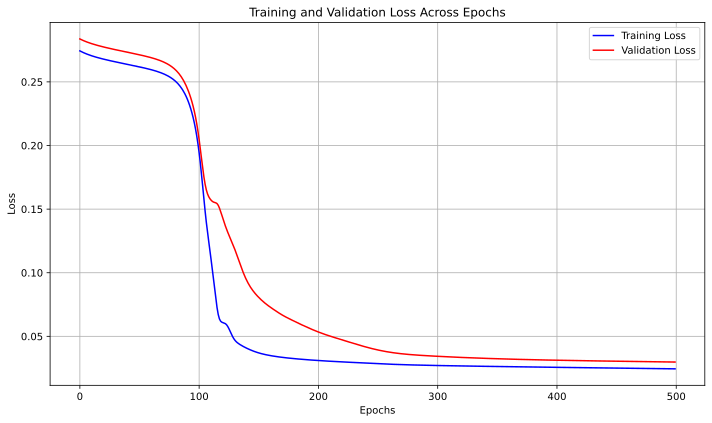

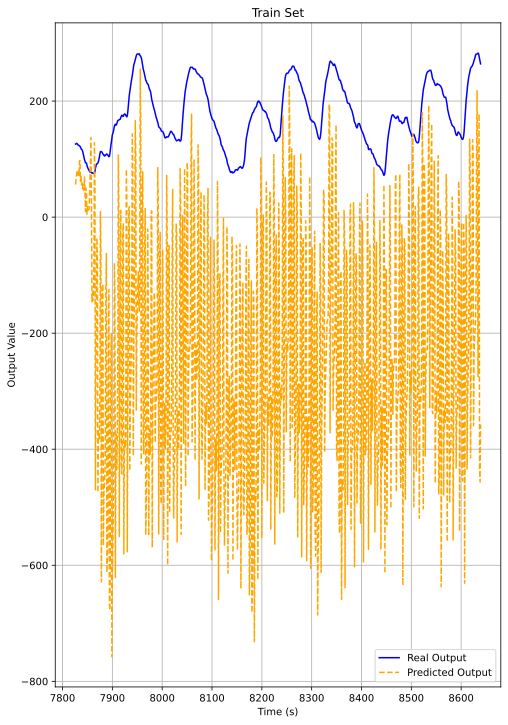

In [15]:
# --------------Plot identification results for S-----------------

#Training and Validation Loss Across Epochs
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_losses, label='Training Loss', color='blue')
plt.plot(range(epochs), val_losses, label='Validation Loss', color='red')  # Assuming val_losses are collected
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Across Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Model's Predictions vs Actual Output for the test set
fig, axes = plt.subplots(nrows=len(test_loader), ncols=1, figsize=(8, 12), sharex=True, sharey=True)

closed_loop_REN_2.to("cpu")

for u0_batch, _, _, u1_batch, y_batch, time in test_loader: # MH, I_rec (PID), R (noise + sat), I_sat (I_rec + R), CGM, time
    # u_batch.shape = batch_size   horizon   input_dim
    
    u0_batch, u1_batch, y_batch= ensure_3d(u0_batch), ensure_3d(u1_batch), ensure_3d(y_batch) # batch_size, time_horizon, input_dim
    u_batch = torch.cat((u0_batch, u1_batch), dim=2)  # concatenate along input dimension
    u_batch, y_batch = u_batch.to("cpu"), y_batch.to("cpu")
    

    closed_loop_REN_2.eval()
    _, y_hat = closed_loop_REN_2(x0, u_batch)
    
    loss_batch_val = MSE(y_batch, y_hat)

    loss_val_epoch += loss_batch_val.item()
    
    y_batch_np = scaler_glucose.denormalize(y_batch.detach().cpu()).numpy()
    y_hat_np = scaler_glucose.denormalize(y_hat.detach().cpu()).numpy()
    


plt.plot(time, y_batch_np[0, :, 0], label="Real Output", color="blue")
plt.plot(time, y_hat_np[0, :, 0], label="Predicted Output", linestyle="--", color="orange")
plt.title(f"Train Set")
plt.xlabel("Time (s)")
plt.ylabel("Output Value")
plt.legend()
plt.grid(True)
plt.show()